#Engine Rating Prediction

The task at hand is to predict the rating of engines based on a given dataset. 



In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.preprocessing import StandardScaler

In [2]:
df = pd.read_excel('/content/Assignment 1 dataset.xlsx')
df.head()

,appointmentId,inspectionStartTime,year,month,engineTransmission_battery_value,engineTransmission_battery_cc_value_0,engineTransmission_battery_cc_value_1,engineTransmission_battery_cc_value_2,engineTransmission_battery_cc_value_3,engineTransmission_battery_cc_value_4,engineTransmission_engineoilLevelDipstick_value,engineTransmission_engineOilLevelDipstick_cc_value_0,engineTransmission_engineOil,engineTransmission_engineOil_cc_value_0,engineTransmission_engineOil_cc_value_1,engineTransmission_engineOil_cc_value_2,engineTransmission_engineOil_cc_value_3,engineTransmission_engineOil_cc_value_4,engineTransmission_engineOil_cc_value_5,engineTransmission_engineOil_cc_value_6,engineTransmission_engineOil_cc_value_7,engineTransmission_engineOil_cc_value_8,engineTransmission_engineOil_cc_value_9,engineTransmission_engine_value,engineTransmission_engine_cc_value_0,engineTransmission_engine_cc_value_1,engineTransmission_engine_cc_value_2,engineTransmission_engine_cc_value_3,engineTransmission_engine_cc_value_4,engineTransmission_engine_cc_value_5,engineTransmission_engine_cc_value_6,engineTransmission_engine_cc_value_7,engineTransmission_engine_cc_value_8,engineTransmission_engine_cc_value_9,engineTransmission_engine_cc_value_10,engineTransmission_coolant_value,engineTransmission_coolant_cc_value_0,engineTransmission_coolant_cc_value_1,engineTransmission_coolant_cc_value_2,engineTransmission_coolant_cc_value_3,engineTransmission_engineMounting_value,engineTransmission_engineMounting_cc_value_0,engineTransmission_engineSound_value,engineTransmission_engineSound_cc_value_0,engineTransmission_engineSound_cc_value_1,engineTransmission_engineSound_cc_value_2,engineTransmission_engineSound_cc_value_3,engineTransmission_engineSound_cc_value_4,engineTransmission_engineSound_cc_value_5,engineTransmission_exhaustSmoke_value,engineTransmission_exhaustSmoke_cc_value_0,engineTransmission_engineBlowByBackCompression_value,engineTransmission_engineBlowByBackCompression_cc_value_0,engineTransmission_clutch_value,engineTransmission_clutch_cc_value_0,engineTransmission_clutch_cc_value_1,engineTransmission_clutch_cc_value_2,engineTransmission_clutch_cc_value_3,engineTransmission_clutch_cc_value_4,engineTransmission_clutch_cc_value_5,engineTransmission_clutch_cc_value_6,engineTransmission_gearShifting_value,engineTransmission_gearShifting_cc_value_0,engineTransmission_gearShifting_cc_value_1,engineTransmission_gearShifting_cc_value_2,engineTransmission_comments_value_0,engineTransmission_comments_value_1,engineTransmission_comments_value_2,engineTransmission_comments_value_3,engineTransmission_comments_value_4,fuel_type,odometer_reading,rating_engineTransmission
0,aj_01,2019-02-03 15:43:48,2008,8,No,Weak,NaN,NaN,NaN,NaN,Yes,NaN,No,Leaking,Dirty,Leakage from Tappet Cover,Leakage from Side cover,NaN,NaN,NaN,NaN,NaN,NaN,No,Repaired,Misfiring,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,Leaking,Dirty,NaN,NaN,No,Excess Vibration,No,Alternator Brg Noise,Water Pump Brg Noise,Timing Noise,Tappet Noise,Engine Auxiliary Noise,NaN,No,White,No,Back Compression Exist,No,Spongy,NaN,NaN,NaN,NaN,NaN,NaN,Yes,NaN,NaN,NaN,Pickup Low,Starter Motor / Solenoid malfunctioning,NaN,NaN,NaN,Petrol + CNG,124600,3.0
1,aj_02,2019-01-16 13:02:12,2007,5,Yes,NaN,NaN,NaN,NaN,NaN,Yes,NaN,No,Leaking,Dirty,Leakage from Tappet Cover,Leakage from Side cover,Leakage from Sump/chamber,NaN,NaN,NaN,NaN,NaN,No,RPM fluctuating,Misfiring,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,Leaking,Dirty,NaN,NaN,Yes,NaN,No,Timing Noise,Tappet Noise,Engine Auxiliary Noise,NaN,NaN,NaN,No,Noise from silencer assembly,Yes,NO Blow-by,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Petrol + CNG,78108,4.0
2,aj_03,2019-02-09 13:31:04,2012,5,Yes,NaN,NaN,NaN,NaN,NaN,Yes,NaN,No,Dirty,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,Dirty,NaN,NaN,NaN,No,Excess Vibration,No,Alternator Brg Noise,Engine Auxiliary Noise,NaN,NaN,NaN,NaN,No,Black,Yes,Perm. Blow By on idle,No,Hard,S

In [3]:
df.shape

(26307, 73)

There are a total of 26307 datapoints with 73 features including the target variable.

In [ ]:
col1 = df.columns

In [ ]:
df['rating_engineTransmission'].value_counts()

4.0    10152
3.5     5944
3.0     4379
4.5     2209
5.0     1623
1.0     1456
2.5      420
2.0      117
1.5        6
0.5        1
Name: rating_engineTransmission, dtype: int64

Obeservation : The target variable (engine rating) that needs to be predicted can be considered to fall into 10 different categories ranging from 0.5 - 5. Therefore I will approach this as a classification task. 

In [4]:
#The column 'appointmentId' doesn't add any value for rating prediction. We will remove that feature.
df = df.drop('appointmentId',axis=1)
df.shape

(26307, 72)

##Removing Duplicates

In [5]:
df = df.drop_duplicates(keep='first')
df = df.T.drop_duplicates().T
df.shape

(26307, 71)

In [ ]:
col2 = df.columns

In [ ]:
set(col1) ^ set(col2)

{'appointmentId', 'engineTransmission_engine_cc_value_10'}

The 'engineTransmission_engine_cc_value_10' column entry is not required since its a duplicate column.

In [6]:
#Finding the total number of features that doesn't have missing values.
c=0
for i in (df.isnull().sum()):
  if i==0:
    c+=1
print("Total number of features that doesn't have any missing values :",c)
print("Total number of features that have missing values :",df.shape[1]-c)

Total number of features that doesn't have any missing values : 18
Total number of features that have missing values : 53


In [ ]:
#Getting the index of those datapoints that have all the other feature values as null expect the aobve 18 features.
index=[]
for i in range(len(df)):
 if df.iloc[i].isnull().values.sum()/(len(df.columns)-18)==1.0:
   index.append(i)
print(len(index))

3092


So, there are a total of 3092 datapoints that have all the values missing for that 53 features. 

In [ ]:
df_missing = df.loc[index]

In [ ]:
df_missing['rating_engineTransmission'].value_counts()

5.0    1333
1.0     957
4.5     438
4.0     331
3.5      29
3.0       4
Name: rating_engineTransmission, dtype: int64

In [ ]:
df_missing.shape

(3092, 71)

In [ ]:
df_missing = df_missing.drop(["inspectionStartTime","year","month","odometer_reading"],axis=1)
target = df_missing["rating_engineTransmission"]
datapoints = df_missing.drop("rating_engineTransmission",axis=1)
duplicates = datapoints[datapoints.duplicated()]
duplicates

,engineTransmission_battery_value,engineTransmission_battery_cc_value_0,engineTransmission_battery_cc_value_1,engineTransmission_battery_cc_value_2,engineTransmission_battery_cc_value_3,engineTransmission_battery_cc_value_4,engineTransmission_engineoilLevelDipstick_value,engineTransmission_engineOilLevelDipstick_cc_value_0,engineTransmission_engineOil,engineTransmission_engineOil_cc_value_0,engineTransmission_engineOil_cc_value_1,engineTransmission_engineOil_cc_value_2,engineTransmission_engineOil_cc_value_3,engineTransmission_engineOil_cc_value_4,engineTransmission_engineOil_cc_value_5,engineTransmission_engineOil_cc_value_6,engineTransmission_engineOil_cc_value_7,engineTransmission_engineOil_cc_value_8,engineTransmission_engineOil_cc_value_9,engineTransmission_engine_value,engineTransmission_engine_cc_value_0,engineTransmission_engine_cc_value_1,engineTransmission_engine_cc_value_2,engineTransmission_engine_cc_value_3,engineTransmission_engine_cc_value_4,engineTransmission_engine_cc_value_5,engineTransmission_engine_cc_value_6,engineTransmission_engine_cc_value_7,engineTransmission_engine_cc_value_8,engineTransmission_engine_cc_value_9,engineTransmission_coolant_value,engineTransmission_coolant_cc_value_0,engineTransmission_coolant_cc_value_1,engineTransmission_coolant_cc_value_2,engineTransmission_coolant_cc_value_3,engineTransmission_engineMounting_value,engineTransmission_engineMounting_cc_value_0,engineTransmission_engineSound_value,engineTransmission_engineSound_cc_value_0,engineTransmission_engineSound_cc_value_1,engineTransmission_engineSound_cc_value_2,engineTransmission_engineSound_cc_value_3,engineTransmission_engineSound_cc_value_4,engineTransmission_engineSound_cc_value_5,engineTransmission_exhaustSmoke_value,engineTransmission_exhaustSmoke_cc_value_0,engineTransmission_engineBlowByBackCompression_value,engineTransmission_engineBlowByBackCompression_cc_value_0,engineTransmission_clutch_value,engineTransmission_clutch_cc_value_0,engineTransmission_clutch_cc_value_1,engineTransmission_clutch_cc_value_2,engineTransmission_clutch_cc_value_3,engineTransmission_clutch_cc_value_4,engineTransmission_clutch_cc_value_5,engineTransmission_clutch_cc_value_6,engineTransmission_gearShifting_value,engineTransmission_gearShifting_cc_value_0,engineTransmission_gearShifting_cc_value_1,engineTransmission_gearShifting_cc_value_2,engineTransmission_comments_value_0,engineTransmission_comments_value_1,engineTransmission_comments_value_2,engineTransmission_comments_value_3,engineTransmission_comments_value_4,fuel_type
26,Yes,NaN,NaN,NaN,NaN,NaN,Yes,NaN,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,NaN,NaN,NaN,NaN,Yes,NaN,Yes,NaN,NaN,NaN,NaN,NaN,NaN,Yes,NaN,Yes,NO Blow-by,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Petrol
38,Yes,NaN,NaN,NaN,NaN,NaN,Yes,NaN,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,NaN,NaN,NaN,NaN,Yes,NaN,Yes,NaN,NaN,NaN,NaN,NaN,NaN,Yes,NaN,Yes,NO Blow-by,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Petrol
79,Yes,NaN,NaN,NaN,NaN,NaN,Yes,NaN,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,NaN,NaN,NaN,NaN,Yes,NaN,Yes,NaN,NaN,NaN,NaN,NaN,NaN,Yes,NaN,Yes,NO Blow-by,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Petrol
93,Yes,NaN,NaN,NaN,NaN,NaN,Yes,NaN,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,NaN,NaN,NaN,NaN,Yes,NaN,Yes,NaN,NaN,NaN,NaN,NaN,NaN,Yes,NaN,Yes,NO Blow-by,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Diesel
98,Yes,NaN,NaN,NaN,NaN,NaN,Yes,NaN,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,NaN,NaN,NaN,NaN,Yes,NaN,Yes,NaN,NaN,NaN,NaN,NaN,NaN,Yes,NaN,Yes,NO Blow-by,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Petrol
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,

In [ ]:
df_missing.loc[duplicates.index]['rating_engineTransmission'].value_counts()

5.0    1327
1.0     954
4.5     436
4.0     326
3.5      28
3.0       4
Name: rating_engineTransmission, dtype: int64

In [ ]:
print("Percentage of datapoints having engine rating = 5.0 : {}%".format((df.loc[duplicates.index]['rating_engineTransmission'].value_counts()[5.0]/df['rating_engineTransmission'].value_counts()[5.0])*100))
print("Percentage of datapoints having engine rating = 4.5 : {}%".format((df.loc[duplicates.index]['rating_engineTransmission'].value_counts()[4.5]/df['rating_engineTransmission'].value_counts()[4.5])*100))
print("Percentage of datapoints having engine rating = 4.0 : {}%".format((df.loc[duplicates.index]['rating_engineTransmission'].value_counts()[4.0]/df['rating_engineTransmission'].value_counts()[4.0])*100))
print("Percentage of datapoints having engine rating = 3.5 : {}%".format((df.loc[duplicates.index]['rating_engineTransmission'].value_counts()[3.5]/df['rating_engineTransmission'].value_counts()[3.5])*100))
print("Percentage of datapoints having engine rating = 3.0 : {}%".format((df.loc[duplicates.index]['rating_engineTransmission'].value_counts()[3.0]/df['rating_engineTransmission'].value_counts()[3.0])*100))
print("Percentage of datapoints having engine rating = 1.0 : {}%".format((df.loc[duplicates.index]['rating_engineTransmission'].value_counts()[1.0]/df['rating_engineTransmission'].value_counts()[1.0])*100))

Percentage of datapoints having engine rating = 5.0 : 81.76216882316697%
Percentage of datapoints having engine rating = 4.5 : 19.73743775464011%
Percentage of datapoints having engine rating = 4.0 : 3.2111899133175728%
Percentage of datapoints having engine rating = 3.5 : 0.47106325706594887%
Percentage of datapoints having engine rating = 3.0 : 0.09134505594884677%
Percentage of datapoints having engine rating = 1.0 : 65.52197802197803%


There are 3075 datapoints that have same features values for all the 66 categorical features, but belonging to different target variable and their percentage is shown above. From the percentage values we can conclude that engines with rating 5.0 and 1.0 are not dependent on the categorical features. Their rating prediction could be dependent on odometer reading and age of the engine. <br>
All these categorical features doesn't play much role in determining its rating. 



#Exploratory Data Analysis

##Addressing Missing Values in column

In [7]:
missing_feature_count = dict(df.drop('rating_engineTransmission',axis=1).isnull().sum())
missing_feature_count = dict(sorted(missing_feature_count.items(), key=lambda x:x[1],reverse=True))

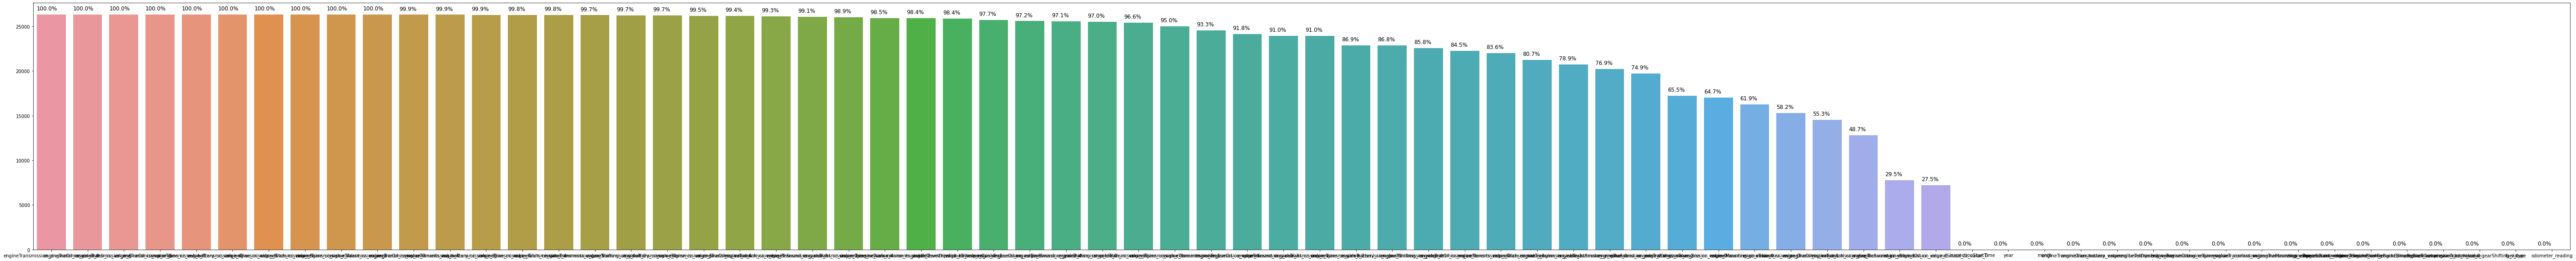

In [ ]:
#https://stackoverflow.com/questions/35692781/python-plotting-percentage-in-seaborn-bar-plot
def barplot(data,sum):
  plt.figure(figsize = (100,10))
  ax = sns.barplot(x = list(data.keys()), y = list(data.values()))

  for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/sum)
    x = p.get_x() 
    y = p.get_height()+500
    ax.annotate(percentage,(x,y),size=12)
barplot(missing_feature_count,df.shape[0])

In [8]:
#Printing few missing value features
c=0
for k,v in missing_feature_count.items():
  if v/len(df) > .90:
    print('column: {} , missing_count: {}'.format(k, v))
    c+=1
print("="*100)
print("The number of features with 90% of its values missing are : ", c)

column: engineTransmission_engineOil_cc_value_9 , missing_count: 26307
column: engineTransmission_clutch_cc_value_6 , missing_count: 26306
column: engineTransmission_engineOil_cc_value_8 , missing_count: 26305
column: engineTransmission_engine_cc_value_9 , missing_count: 26304
column: engineTransmission_battery_cc_value_4 , missing_count: 26303
column: engineTransmission_engine_cc_value_8 , missing_count: 26303
column: engineTransmission_clutch_cc_value_5 , missing_count: 26300
column: engineTransmission_engine_cc_value_7 , missing_count: 26299
column: engineTransmission_coolant_cc_value_3 , missing_count: 26299
column: engineTransmission_engineOil_cc_value_7 , missing_count: 26296
column: engineTransmission_comments_value_4 , missing_count: 26293
column: engineTransmission_battery_cc_value_3 , missing_count: 26291
column: engineTransmission_engine_cc_value_6 , missing_count: 26270
column: engineTransmission_clutch_cc_value_4 , missing_count: 26264
column: engineTransmission_comments_v

36 features having more than 90% of their values missing. It is difficult to impute the missing values since the % of data missing is high.

So, we will consider the missing value as a 'Nan' category.

In [9]:
df = df.drop('engineTransmission_engineOil_cc_value_9',axis=1) #dropping this feature since all the feature values are missing

In [10]:
#Printing few missing value features
c=0
for k,v in missing_feature_count.items():
  if v/len(df) < 0.5:
    print('column: {} , missing_count: {}'.format(k, v))
    c+=1
print("="*100)
print("The number of features with missing values less than 50% : ", c)

column: engineTransmission_engineSound_cc_value_1 , missing_count: 12802
column: engineTransmission_engineOil_cc_value_0 , missing_count: 7750
column: engineTransmission_engineSound_cc_value_0 , missing_count: 7227
column: inspectionStartTime , missing_count: 0
column: year , missing_count: 0
column: month , missing_count: 0
column: engineTransmission_battery_value , missing_count: 0
column: engineTransmission_engineoilLevelDipstick_value , missing_count: 0
column: engineTransmission_engineOil , missing_count: 0
column: engineTransmission_engine_value , missing_count: 0
column: engineTransmission_coolant_value , missing_count: 0
column: engineTransmission_engineMounting_value , missing_count: 0
column: engineTransmission_engineSound_value , missing_count: 0
column: engineTransmission_exhaustSmoke_value , missing_count: 0
column: engineTransmission_engineBlowByBackCompression_value , missing_count: 0
column: engineTransmission_engineBlowByBackCompression_cc_value_0 , missing_count: 0
co

In [11]:
missing_feature_count = dict(df.drop('rating_engineTransmission',axis=1).isnull().sum())
missing_feature_count = dict(sorted(missing_feature_count.items(), key=lambda x:x[1],reverse=True))
missing_feature_cols = []
for k,v in missing_feature_count.items():
  if v/len(df) != 0.0:
    #print('column: {} , missing_count: {}'.format(k, v))
    missing_feature_cols.append(k)
print("="*100)
print("The number of features that has missing values  : ", len(missing_feature_cols))

The number of features that has missing values  :  52


##Analyzing the target variable

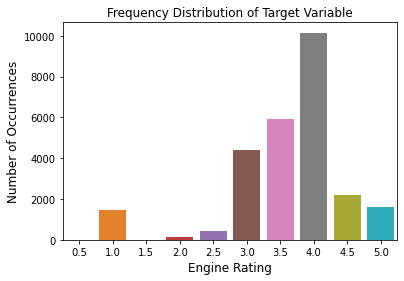

In [ ]:
sns.barplot(x=df['rating_engineTransmission'].value_counts().index, y=df['rating_engineTransmission'].value_counts().values)
plt.title('Frequency Distribution of Target Variable')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Engine Rating', fontsize=12)
plt.show()

Majority of the datapoints have engine rating as 4. Also, the data is very imbalanced.

In [ ]:
df['rating_engineTransmission'].value_counts()

4.0    10152
3.5     5944
3.0     4379
4.5     2209
5.0     1623
1.0     1456
2.5      420
2.0      117
1.5        6
0.5        1
Name: rating_engineTransmission, dtype: int64

In [ ]:
df[df['rating_engineTransmission']==0.5]

,inspectionStartTime,year,month,engineTransmission_battery_value,engineTransmission_battery_cc_value_0,engineTransmission_battery_cc_value_1,engineTransmission_battery_cc_value_2,engineTransmission_battery_cc_value_3,engineTransmission_battery_cc_value_4,engineTransmission_engineoilLevelDipstick_value,engineTransmission_engineOilLevelDipstick_cc_value_0,engineTransmission_engineOil,engineTransmission_engineOil_cc_value_0,engineTransmission_engineOil_cc_value_1,engineTransmission_engineOil_cc_value_2,engineTransmission_engineOil_cc_value_3,engineTransmission_engineOil_cc_value_4,engineTransmission_engineOil_cc_value_5,engineTransmission_engineOil_cc_value_6,engineTransmission_engineOil_cc_value_7,engineTransmission_engineOil_cc_value_8,engineTransmission_engine_value,engineTransmission_engine_cc_value_0,engineTransmission_engine_cc_value_1,engineTransmission_engine_cc_value_2,engineTransmission_engine_cc_value_3,engineTransmission_engine_cc_value_4,engineTransmission_engine_cc_value_5,engineTransmission_engine_cc_value_6,engineTransmission_engine_cc_value_7,engineTransmission_engine_cc_value_8,engineTransmission_engine_cc_value_9,engineTransmission_coolant_value,engineTransmission_coolant_cc_value_0,engineTransmission_coolant_cc_value_1,engineTransmission_coolant_cc_value_2,engineTransmission_coolant_cc_value_3,engineTransmission_engineMounting_value,engineTransmission_engineMounting_cc_value_0,engineTransmission_engineSound_value,engineTransmission_engineSound_cc_value_0,engineTransmission_engineSound_cc_value_1,engineTransmission_engineSound_cc_value_2,engineTransmission_engineSound_cc_value_3,engineTransmission_engineSound_cc_value_4,engineTransmission_engineSound_cc_value_5,engineTransmission_exhaustSmoke_value,engineTransmission_exhaustSmoke_cc_value_0,engineTransmission_engineBlowByBackCompression_value,engineTransmission_engineBlowByBackCompression_cc_value_0,engineTransmission_clutch_value,engineTransmission_clutch_cc_value_0,engineTransmission_clutch_cc_value_1,engineTransmission_clutch_cc_value_2,engineTransmission_clutch_cc_value_3,engineTransmission_clutch_cc_value_4,engineTransmission_clutch_cc_value_5,engineTransmission_clutch_cc_value_6,engineTransmission_gearShifting_value,engineTransmission_gearShifting_cc_value_0,engineTransmission_gearShifting_cc_value_1,engineTransmission_gearShifting_cc_value_2,engineTransmission_comments_value_0,engineTransmission_comments_value_1,engineTransmission_comments_value_2,engineTransmission_comments_value_3,engineTransmission_comments_value_4,fuel_type,odometer_reading,rating_engineTransmission
16022,2019-04-02 17:39:25,2004,1,Yes,NaN,NaN,NaN,NaN,NaN,Yes,NaN,No,Dirty,Leakage from Tappet Cover,Leakage from Side cover,NaN,NaN,NaN,NaN,NaN,NaN,No,RPM fluctuating,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,Dirty,NaN,NaN,NaN,No,Excess Vibration,No,Alternator Brg Noise,Timing Noise,NaN,NaN,NaN,NaN,No,Silencer assembly damaged,Yes,NO Blow-by,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Petrol + CNG,54761,0.5


There is only one data point with rating 0.5. We will remove this datapoint since the model cannot learn anything from a single datapoint for a particular target variable.

In [12]:
df.drop(16022,inplace=True)
df = df.reset_index(drop=True)

##Univariate analysis on some categorical features with missing values greater than 90%

In [ ]:
def univariate_barplots(df,col1,col2):
  df=df.fillna('Entry Missing')
  temp = df.groupby(col1,dropna=False)[col2]
  l = len(temp)
  c=0
  fig,axes = plt.subplots(1,l,figsize=(40,10))
  for i,j in temp:
    sns.barplot(x=j.value_counts(dropna=False).keys(),y=j.value_counts(dropna=False),ax=axes[c])
    axes[c].set_title(i)
    axes[c].set_ylabel('Number of Occurrences', fontsize=12)
    axes[c].set_xlabel('Engine Rating', fontsize=12)
    c+=1

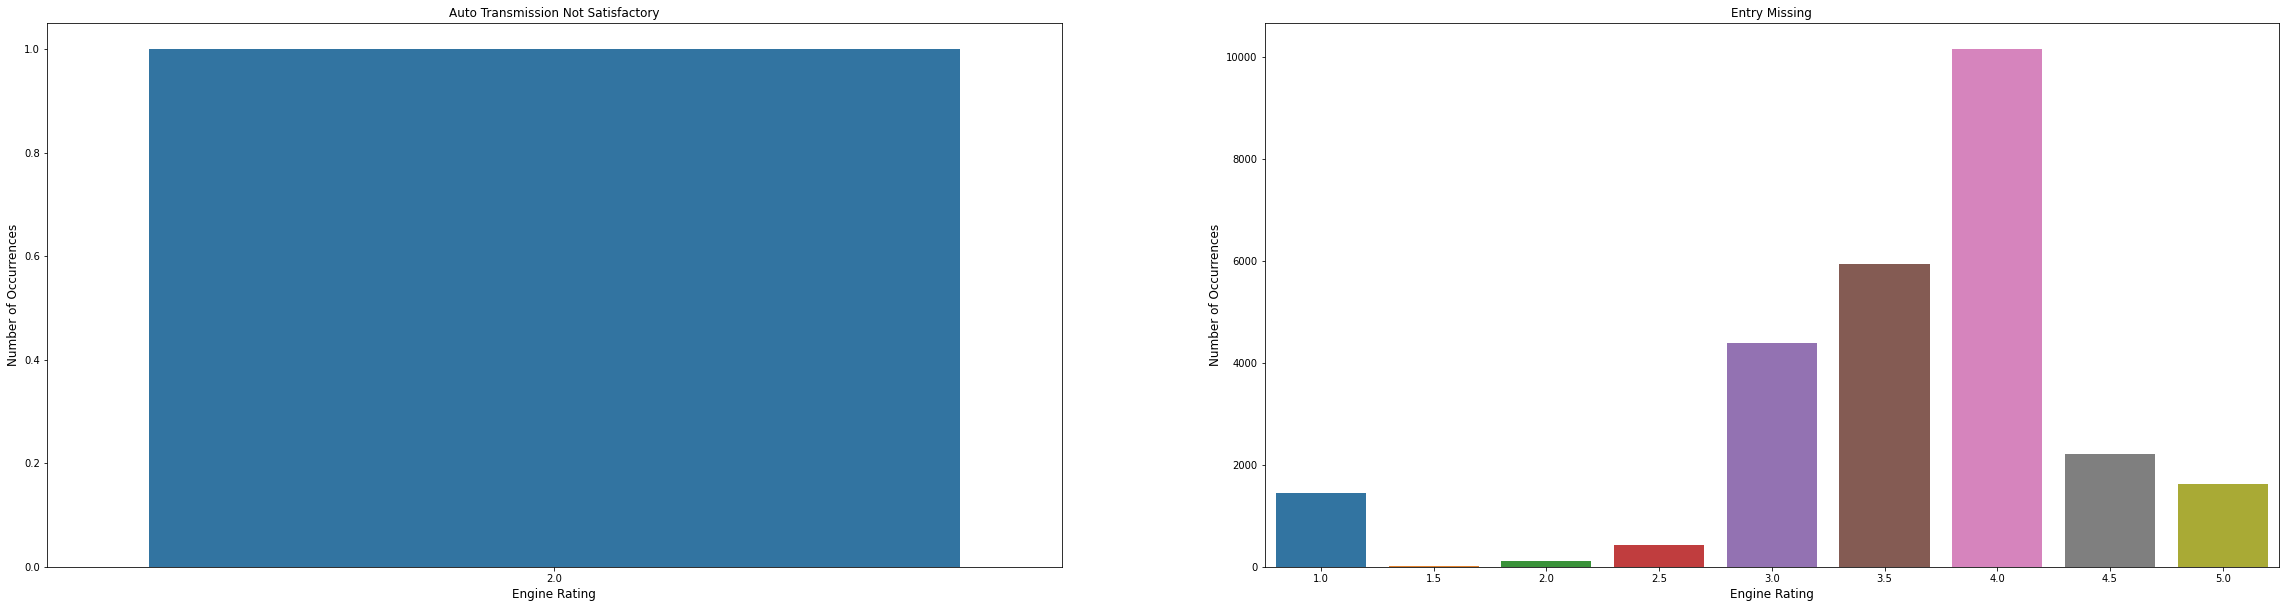

In [ ]:
univariate_barplots(df,col1 = 'engineTransmission_clutch_cc_value_6',col2 = 'rating_engineTransmission')

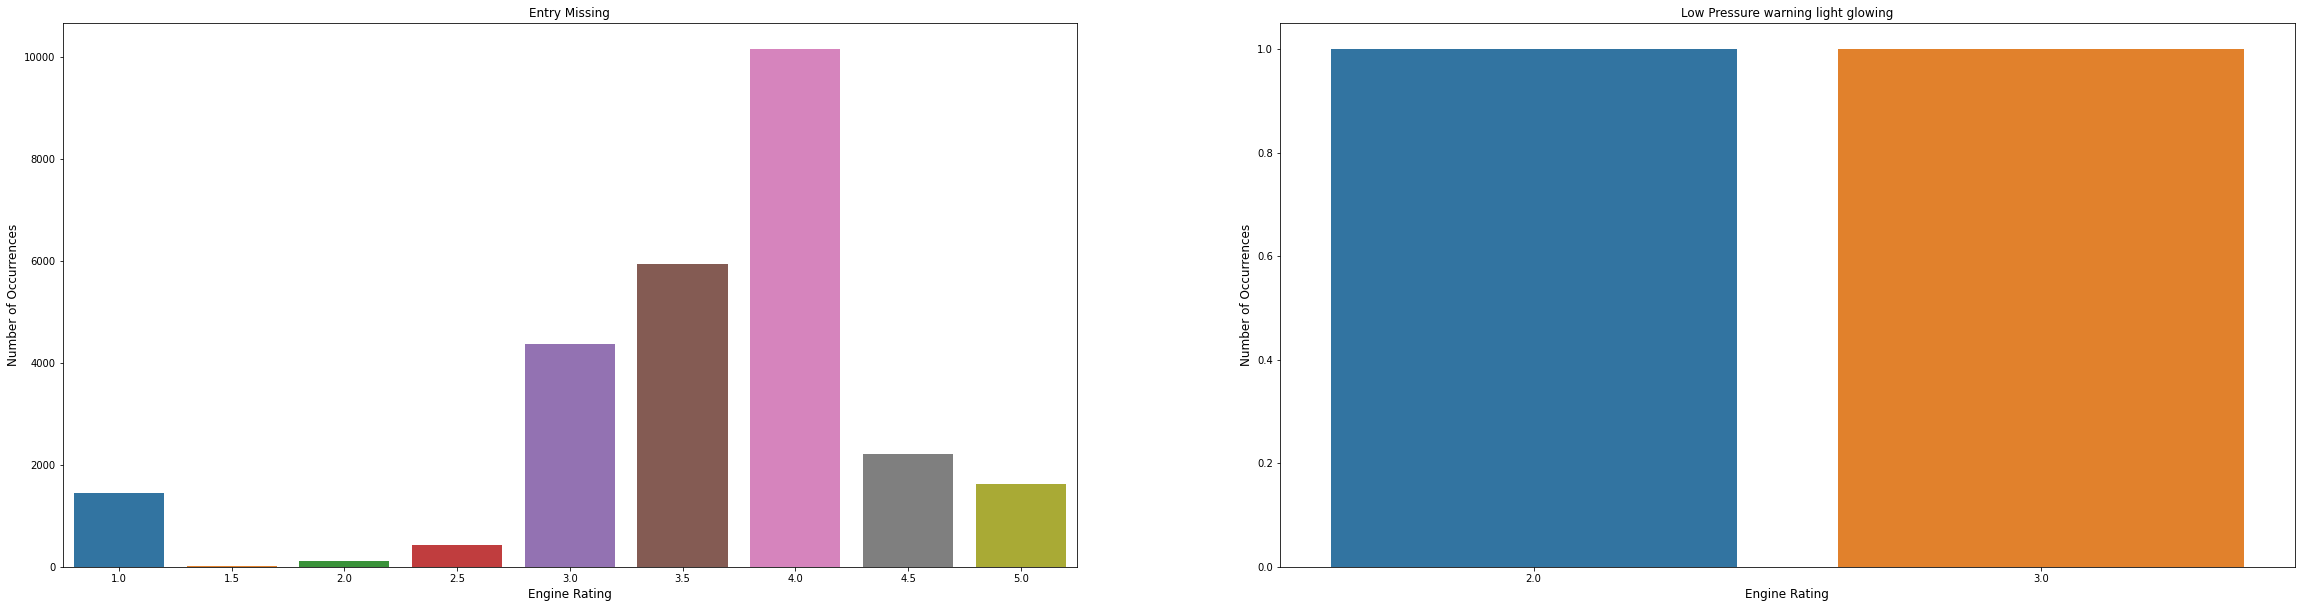

In [ ]:
univariate_barplots(df,col1 = 'engineTransmission_engineOil_cc_value_8',col2 = 'rating_engineTransmission')

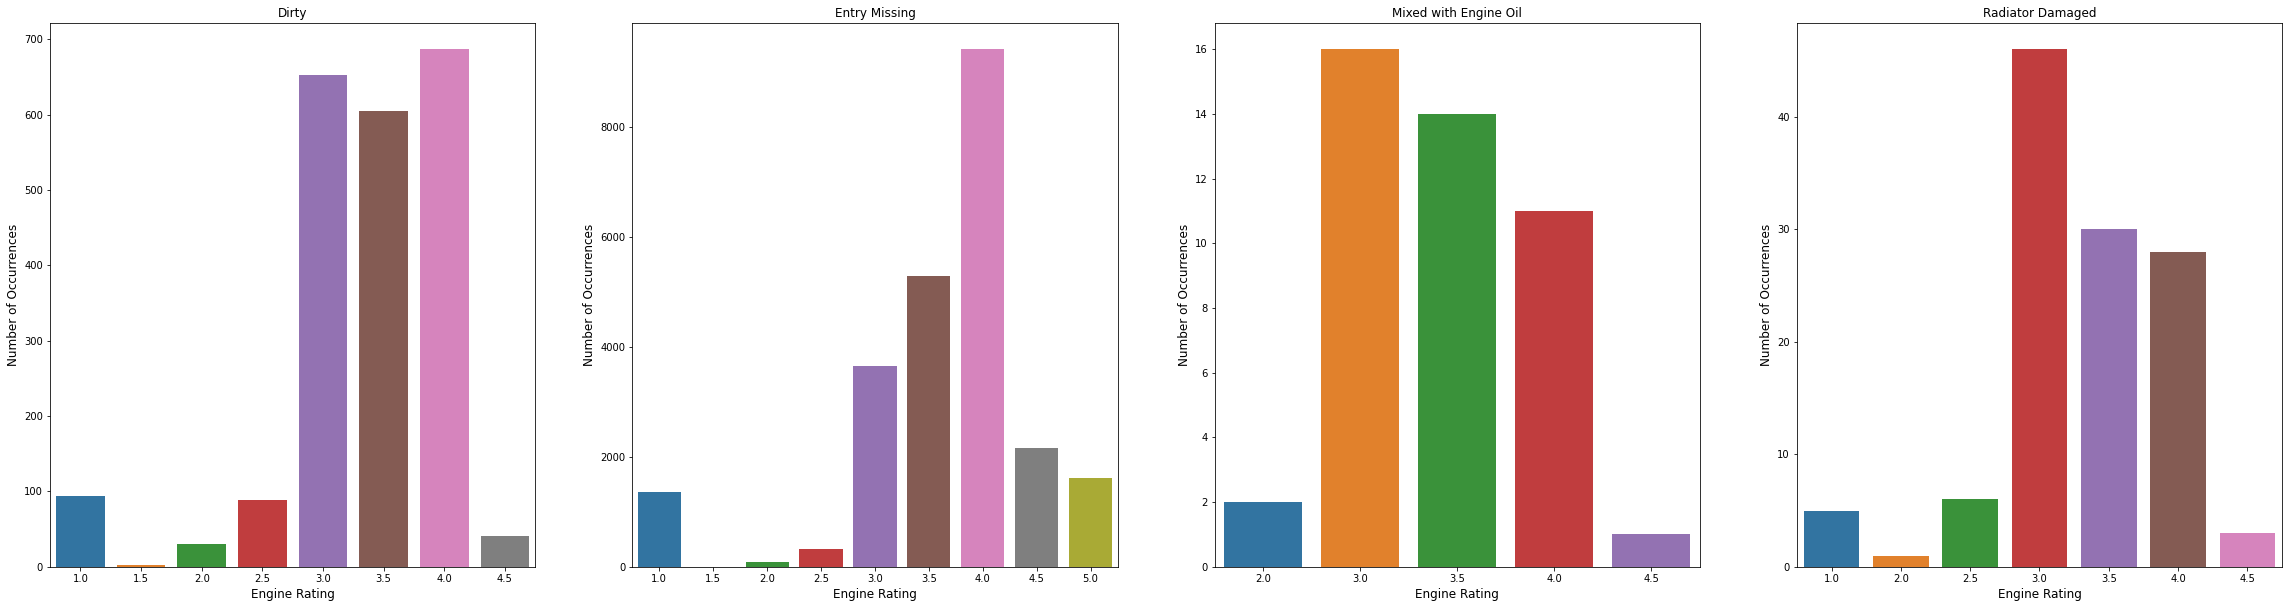

In [ ]:
univariate_barplots(df,col1 = 'engineTransmission_coolant_cc_value_1',col2 = 'rating_engineTransmission')

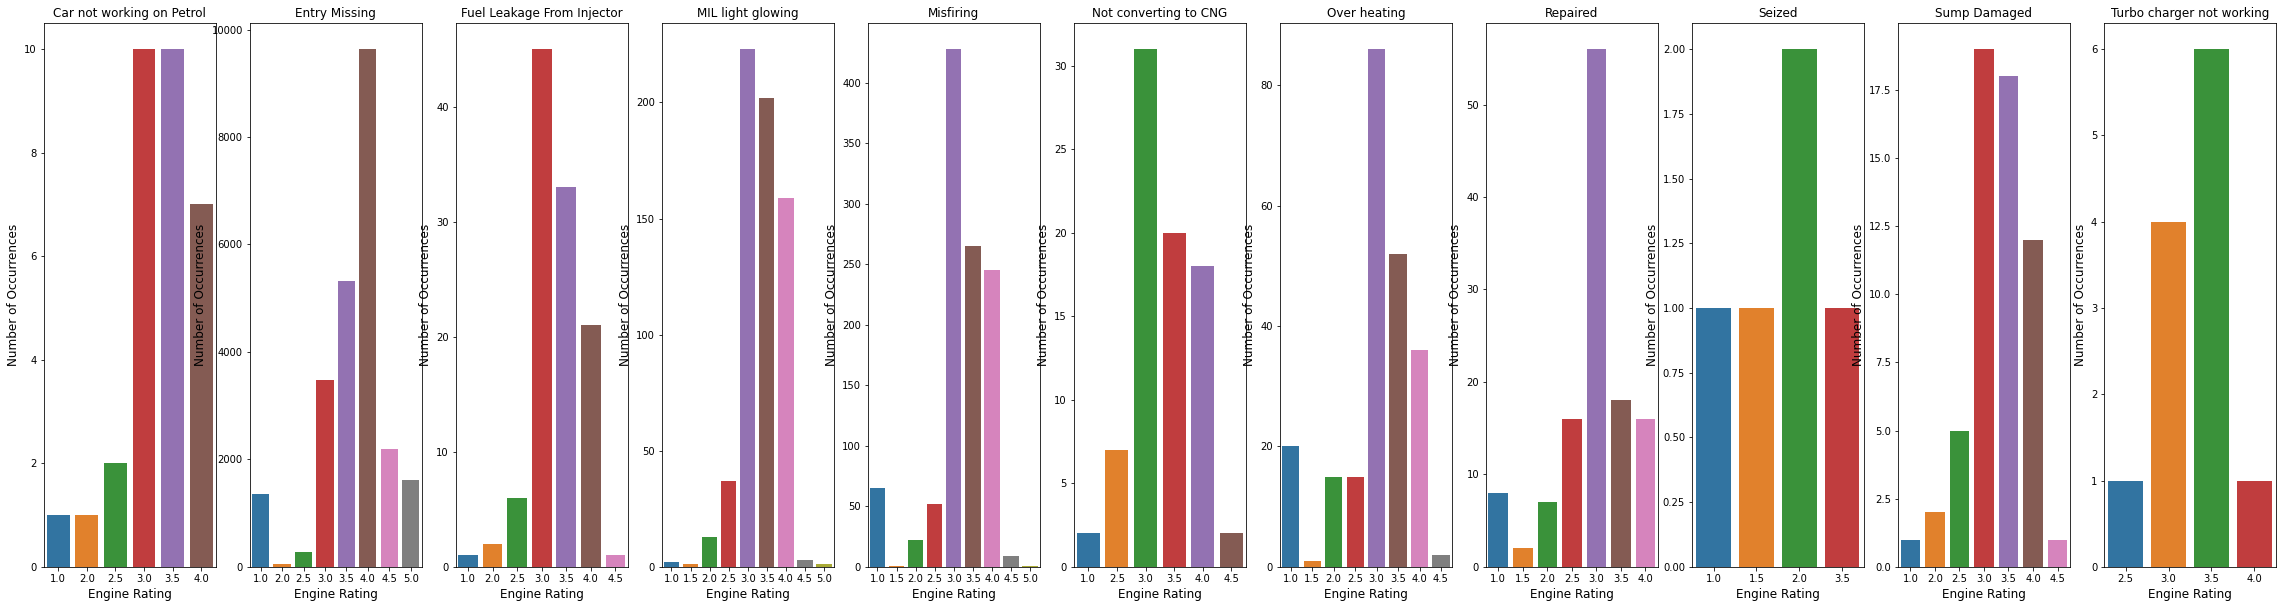

In [ ]:
univariate_barplots(df,col1 = 'engineTransmission_engine_cc_value_2',col2 = 'rating_engineTransmission')

One common observation from the above barplots on categorical features is that, the missing value category distribution is same for all these features, with majority of datapoints belonging to engine rating 4.



##Univariate analysis on some categorical features with missing values less than 50%

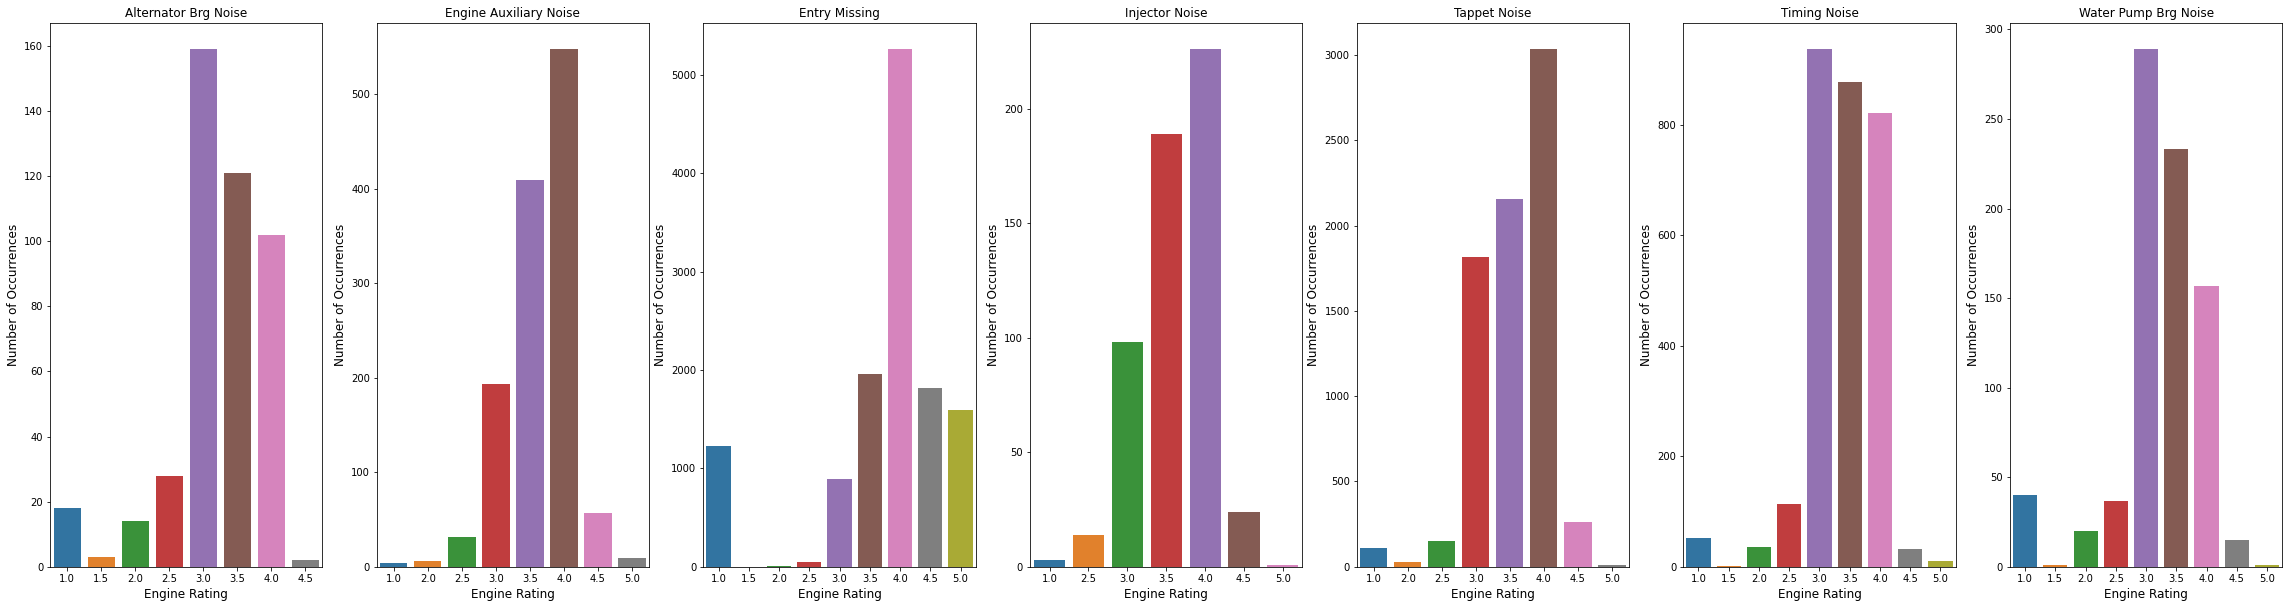

In [ ]:
univariate_barplots(df,col1 = 'engineTransmission_engineSound_cc_value_1',col2 = 'rating_engineTransmission')

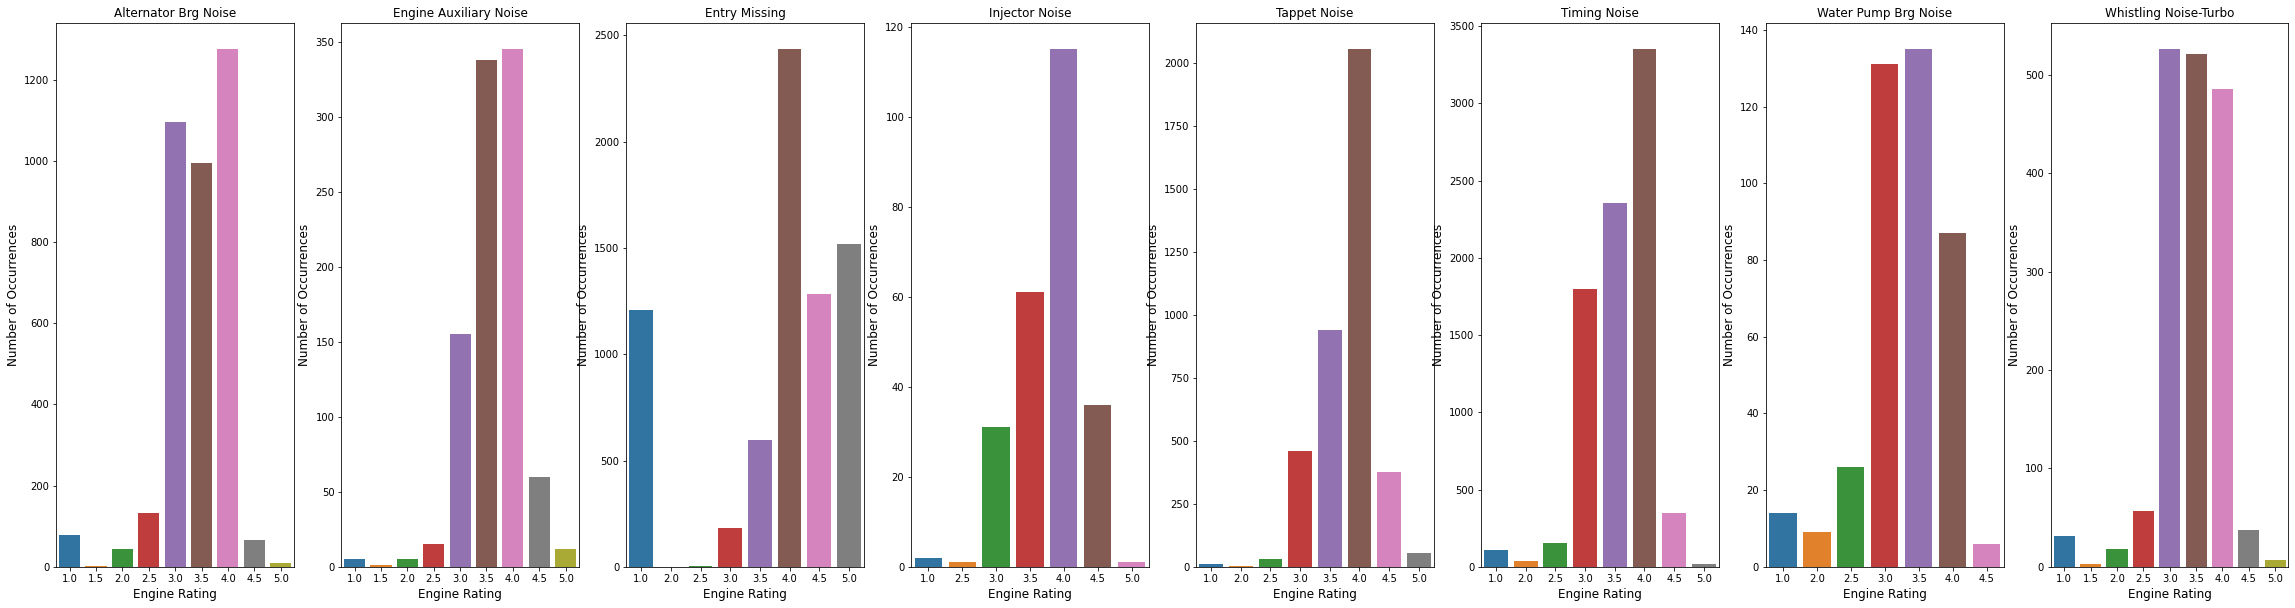

In [ ]:
univariate_barplots(df,col1 = 'engineTransmission_engineSound_cc_value_0',col2 = 'rating_engineTransmission')

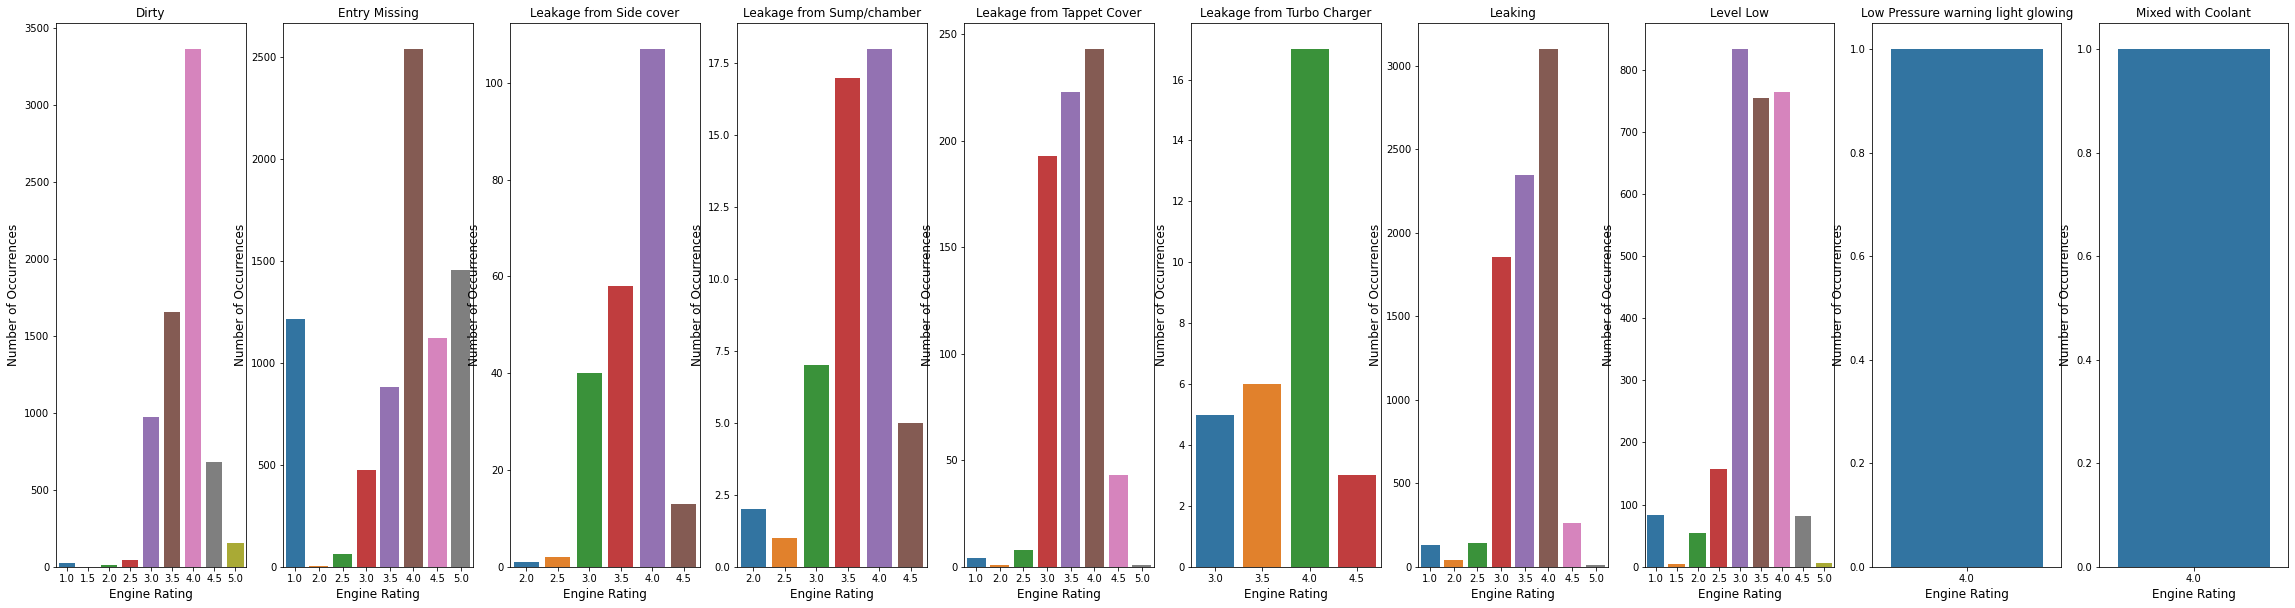

In [ ]:
univariate_barplots(df,col1 = 'engineTransmission_engineOil_cc_value_0',col2 = 'rating_engineTransmission')

One common observation found in the above features is that, engine rating 4 is high for any categorical feature value. i.e irrespective of what category each of these features belong to, engine rating is 4 majority of times. Also, it would be difficult to classify datapoints belonging to rating 3.0, 3.5, 4.0 since there is a many datapoints belonging to these rating for same categorical features.

##Univariate Analysis on some categorical features with category as 'Yes' or 'No'.

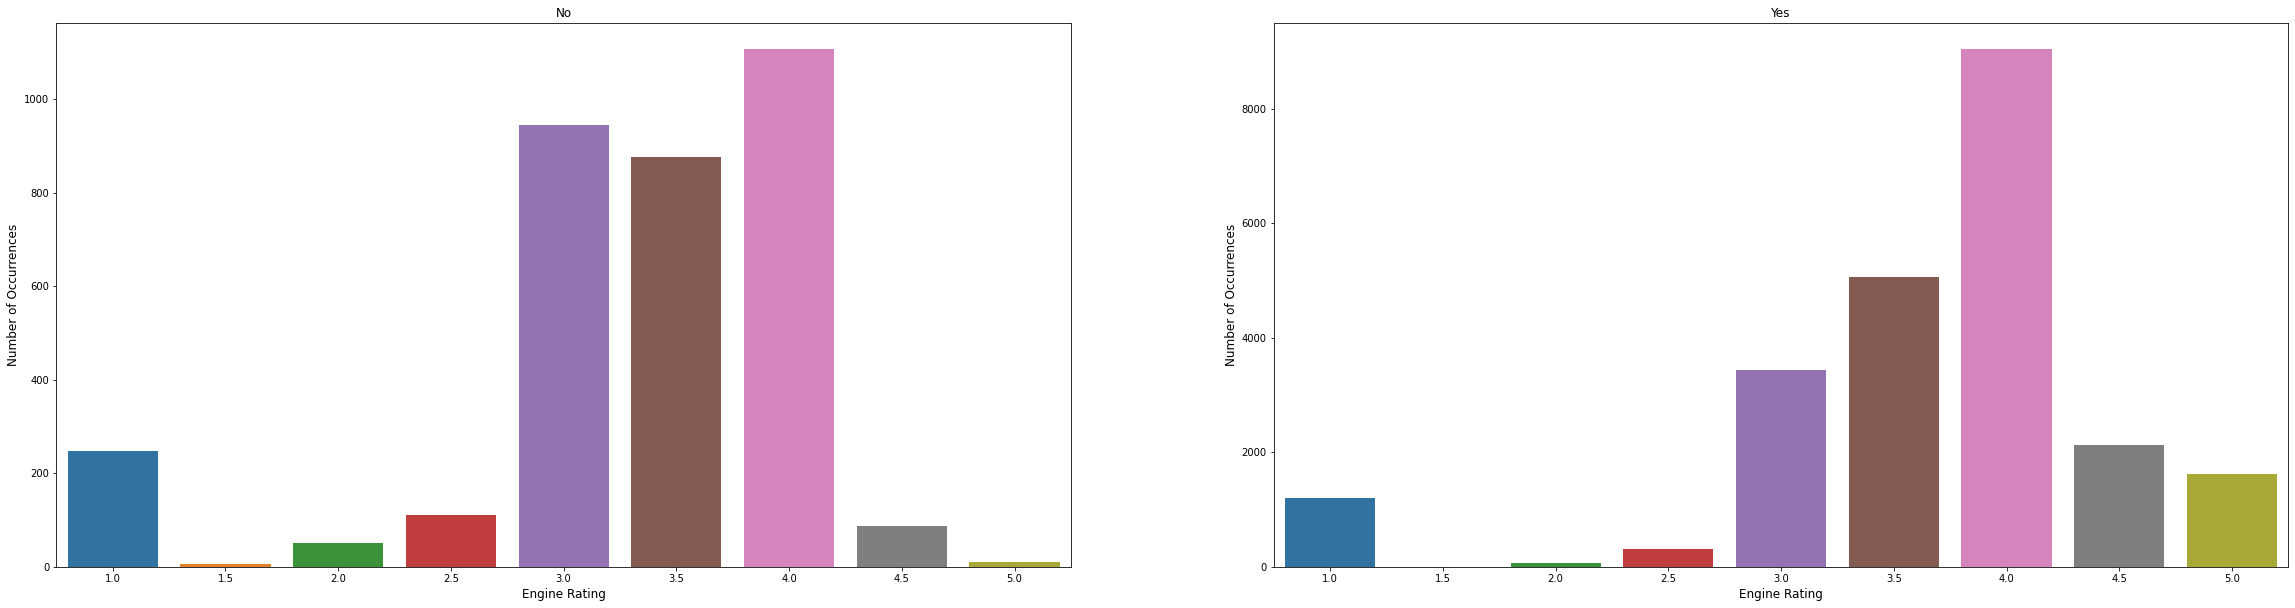

In [ ]:
univariate_barplots(df,col1 = 'engineTransmission_battery_value',col2 = 'rating_engineTransmission')

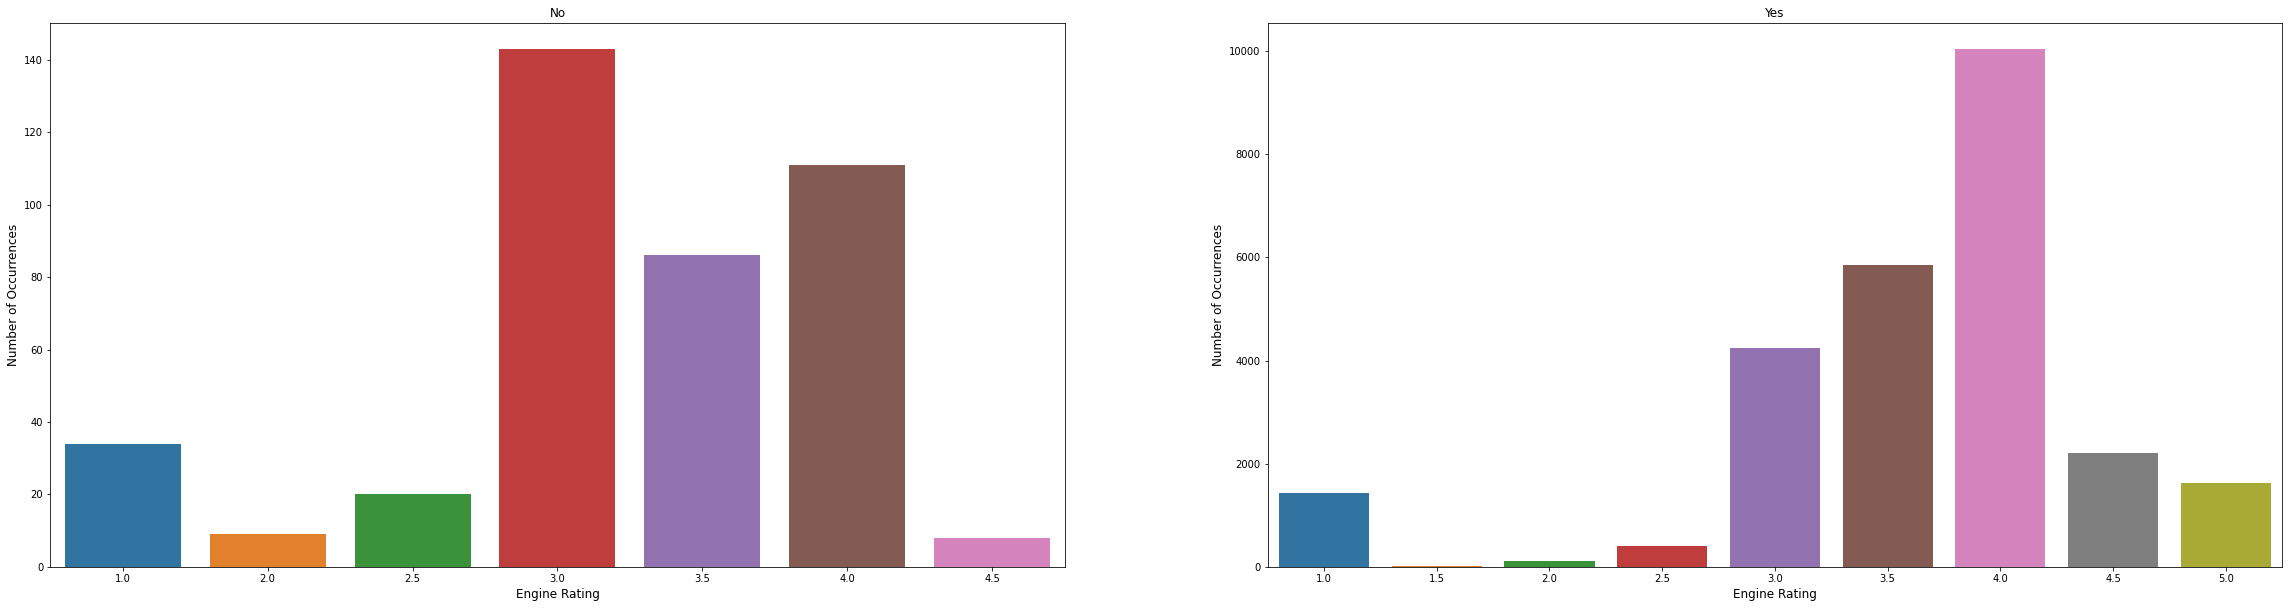

In [ ]:
univariate_barplots(df,col1 = 'engineTransmission_engineoilLevelDipstick_value',col2 = 'rating_engineTransmission')

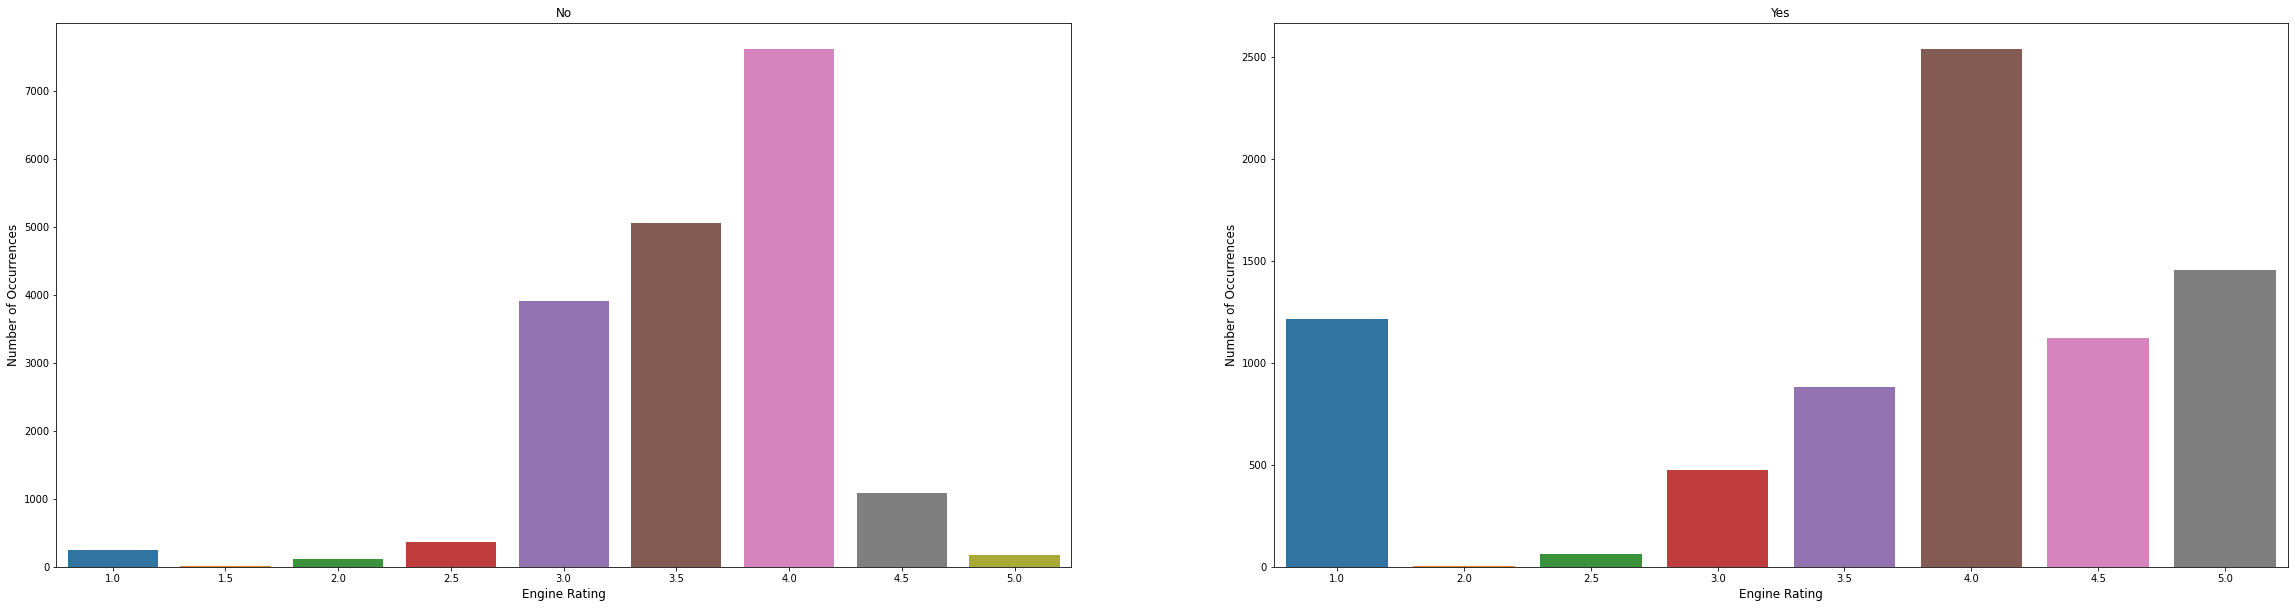

In [ ]:
univariate_barplots(df,col1 = 'engineTransmission_engineOil',col2 = 'rating_engineTransmission')

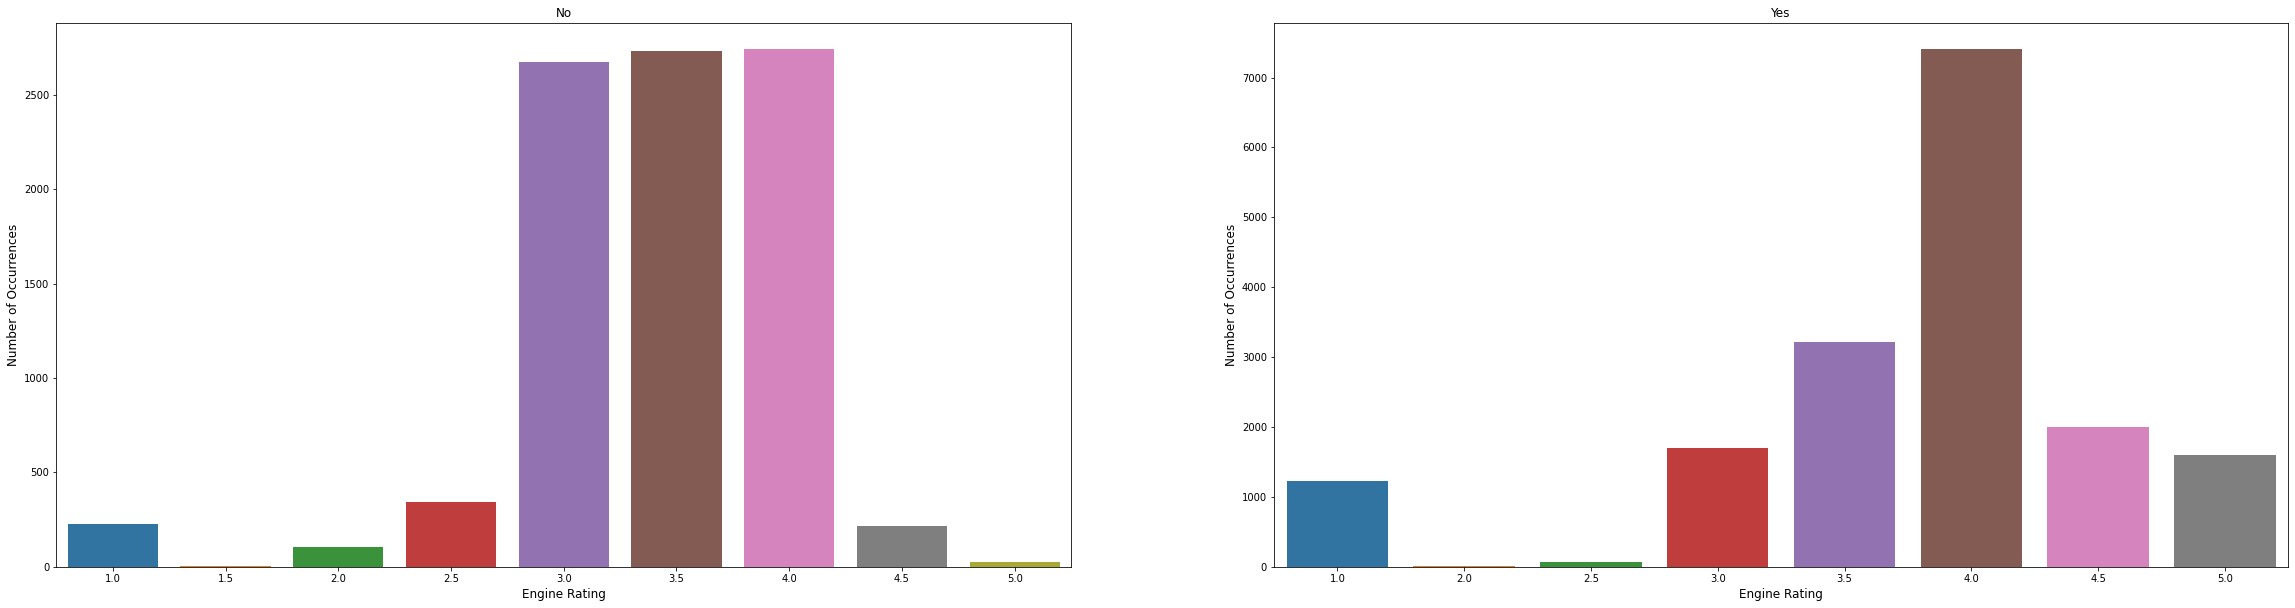

In [ ]:
univariate_barplots(df,col1 = 'engineTransmission_engine_value',col2 = 'rating_engineTransmission')

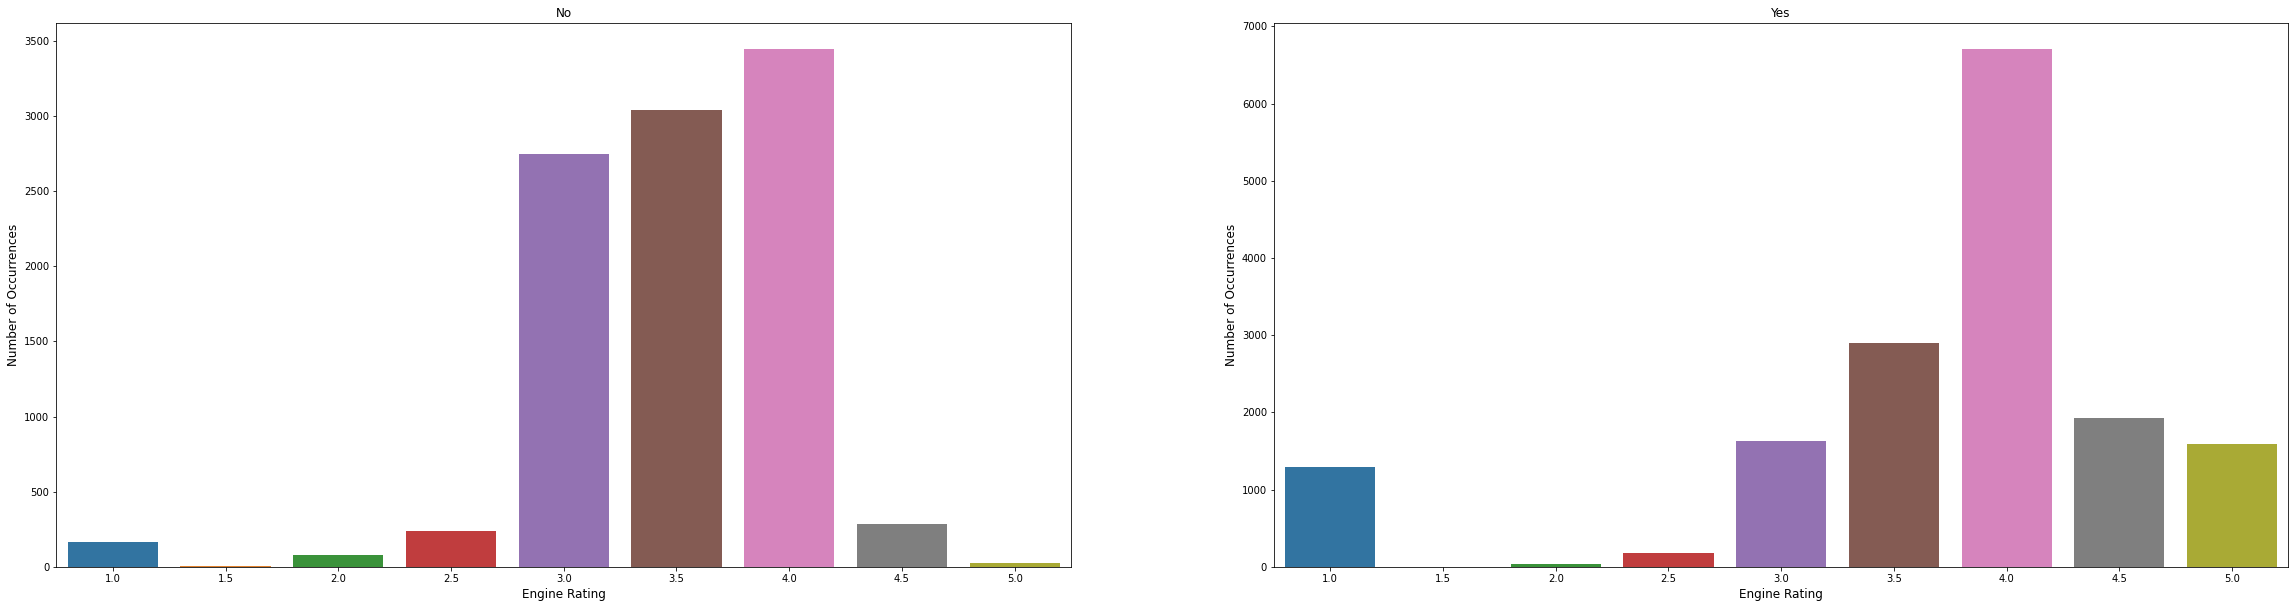

In [ ]:
univariate_barplots(df,col1 = 'engineTransmission_coolant_value',col2 = 'rating_engineTransmission')

For both categories ('Yes' and 'No'), there are many datapoints belonging to rating 3.0 , 3.5 and 4.0.<br> So, these features doesn't help in classifying between engine rating 3.0,3.5 and 4.0.<br> But using these features we can classify engine rating 1.0, 4.5 and 5.0 from engine ratings 3.0, 3.5 and 4.0. <br>If the category is 'No' for these features, then chances are low for engine rating to be 1.0, 4.5 and 5.0. 

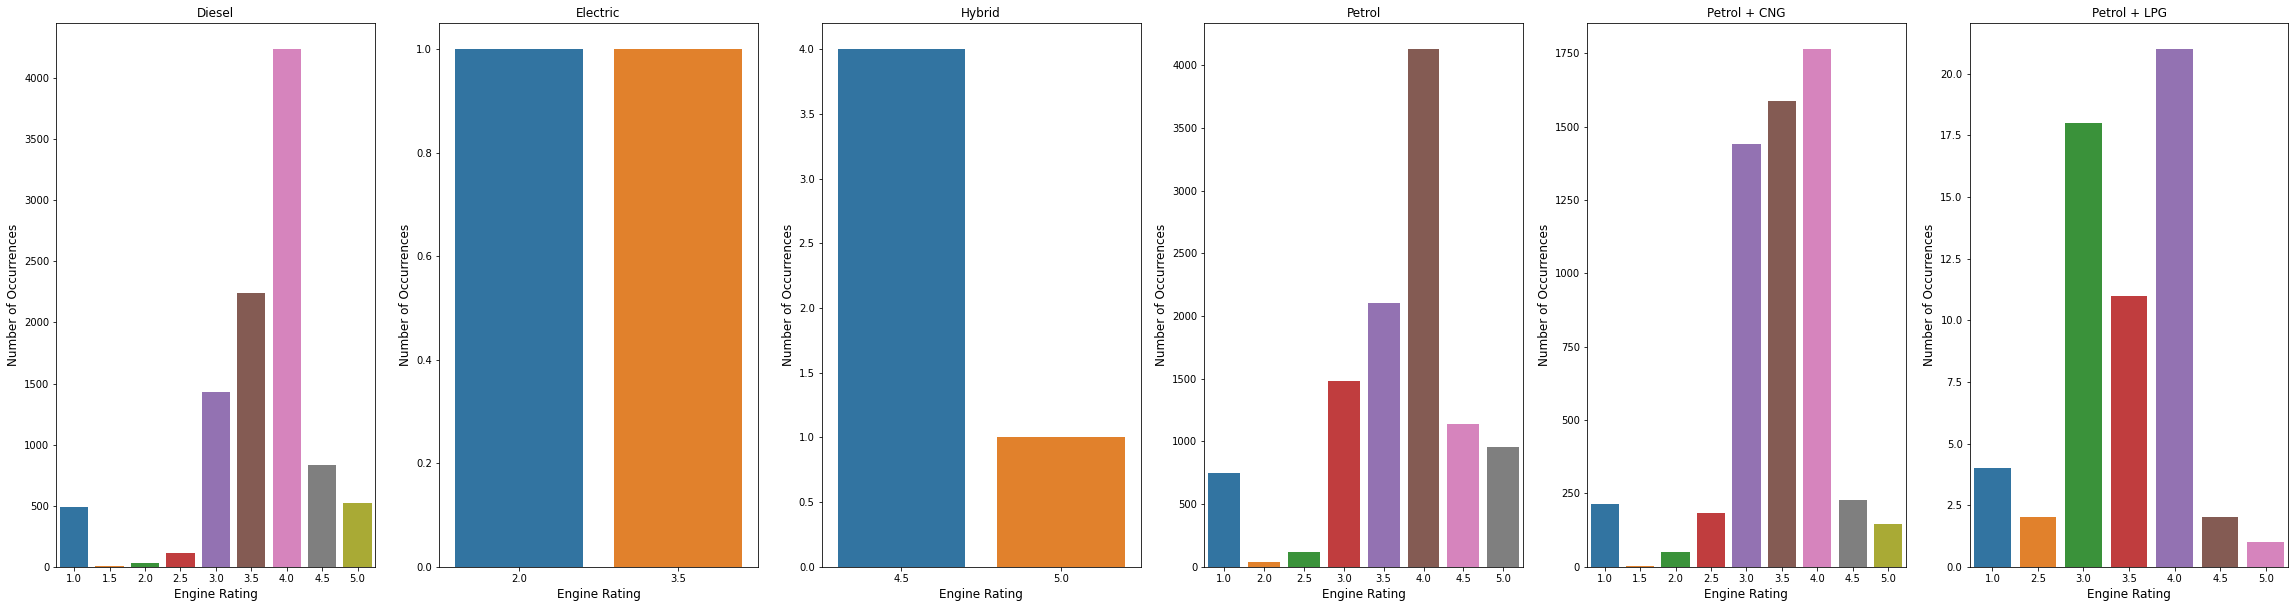

In [ ]:
univariate_barplots(df,col1 = 'fuel_type',col2 = 'rating_engineTransmission')

Majority of the vehicle runs on Diesel and Petrol engines and have engine rating of 4. Very few vechicles are electric/hybrid. 

##Analzing the numerical features

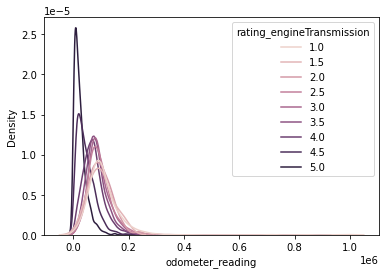

In [ ]:
sns.kdeplot(x='odometer_reading', data=df, hue='rating_engineTransmission', cumulative=False, common_norm=False)

It is clear that smaller the odometer reading (km's travelled), better is the engine rating and vice versa

In [13]:
#Getting the number of months between engine manufacture and inspection
insp_dates = pd.DatetimeIndex(df['inspectionStartTime'])
man_year = df['year']
man_month = df['month']
def diff_month(d1, d2):
   # print((d1.year - d2.year) * 12 + d1.month - d2.month)
    return (d1.year - d2.year) * 12 + d1.month - d2.month

age = []
for i in range(len(df)):
  age.append(diff_month(insp_dates[i],datetime(man_year[i],man_month[i],1)))
df['Age'] = age
df = df.drop(['inspectionStartTime','year','month'],axis=1)

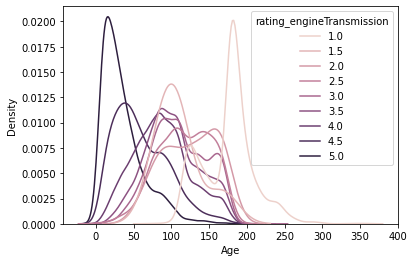

In [ ]:
sns.kdeplot(x='Age', data=df, hue='rating_engineTransmission', cumulative=False, common_norm=False)

Age here refers to the difference in months between data of inspection and year of manufacture of engine. All the engines were inspected in the 2019. So, this age feature actually represents the age of engine. 

From the plot, its clear that new engines have better engine rating and as the age of the engine increases, the engine rating is also decreasing. 



#Feature Engineering

##Loading the data

In [14]:
#df1 = df.copy()
#df = df1.copy()

In [15]:
df = df.fillna('Null')

In [16]:
for col in missing_feature_cols:
  df[col+'_fe']= df[col].isnull().astype(int)
df

,engineTransmission_battery_value,engineTransmission_battery_cc_value_0,engineTransmission_battery_cc_value_1,engineTransmission_battery_cc_value_2,engineTransmission_battery_cc_value_3,engineTransmission_battery_cc_value_4,engineTransmission_engineoilLevelDipstick_value,engineTransmission_engineOilLevelDipstick_cc_value_0,engineTransmission_engineOil,engineTransmission_engineOil_cc_value_0,engineTransmission_engineOil_cc_value_1,engineTransmission_engineOil_cc_value_2,engineTransmission_engineOil_cc_value_3,engineTransmission_engineOil_cc_value_4,engineTransmission_engineOil_cc_value_5,engineTransmission_engineOil_cc_value_6,engineTransmission_engineOil_cc_value_7,engineTransmission_engineOil_cc_value_8,engineTransmission_engine_value,engineTransmission_engine_cc_value_0,engineTransmission_engine_cc_value_1,engineTransmission_engine_cc_value_2,engineTransmission_engine_cc_value_3,engineTransmission_engine_cc_value_4,engineTransmission_engine_cc_value_5,engineTransmission_engine_cc_value_6,engineTransmission_engine_cc_value_7,engineTransmission_engine_cc_value_8,engineTransmission_engine_cc_value_9,engineTransmission_coolant_value,engineTransmission_coolant_cc_value_0,engineTransmission_coolant_cc_value_1,engineTransmission_coolant_cc_value_2,engineTransmission_coolant_cc_value_3,engineTransmission_engineMounting_value,engineTransmission_engineMounting_cc_value_0,engineTransmission_engineSound_value,engineTransmission_engineSound_cc_value_0,engineTransmission_engineSound_cc_value_1,engineTransmission_engineSound_cc_value_2,...,engineTransmission_clutch_cc_value_4_fe,engineTransmission_comments_value_3_fe,engineTransmission_gearShifting_cc_value_2_fe,engineTransmission_battery_cc_value_2_fe,engineTransmission_engine_cc_value_5_fe,engineTransmission_engineOil_cc_value_6_fe,engineTransmission_clutch_cc_value_3_fe,engineTransmission_engineSound_cc_value_5_fe,engineTransmission_coolant_cc_value_2_fe,engineTransmission_engine_cc_value_4_fe,engineTransmission_comments_value_2_fe,engineTransmission_engineOilLevelDipstick_cc_value_0_fe,engineTransmission_battery_cc_value_1_fe,engineTransmission_engineOil_cc_value_5_fe,engineTransmission_engineSound_cc_value_4_fe,engineTransmission_gearShifting_cc_value_1_fe,engineTransmission_clutch_cc_value_2_fe,engineTransmission_engine_cc_value_3_fe,engineTransmission_comments_value_1_fe,engineTransmission_engineOil_cc_value_4_fe,engineTransmission_engineSound_cc_value_3_fe,engineTransmission_coolant_cc_value_1_fe,engineTransmission_engine_cc_value_2_fe,engineTransmission_battery_cc_value_0_fe,engineTransmission_gearShifting_cc_value_0_fe,engineTransmission_engineOil_cc_value_3_fe,engineTransmission_comments_value_0_fe,engineTransmission_clutch_cc_value_1_fe,engineTransmission_engine_cc_value_1_fe,engineTransmission_exhaustSmoke_cc_value_0_fe,engineTransmission_engineSound_cc_value_2_fe,engineTransmission_engineOil_cc_value_2_fe,engineTransmission_engine_cc_value_0_fe,engineTransmission_engineMounting_cc_value_0_fe,engineTransmission_coolant_cc_value_0_fe,engineTransmission_engineOil_cc_value_1_fe,engineTransmission_clutch_cc_value_0_fe,engineTransmission_engineSound_cc_value_1_fe,engineTransmission_engineOil_cc_value_0_fe,engineTransmission_engineSound_cc_value_0_fe
0,No,Weak,Null,Null,Null,Null,Yes,Null,No,Leaking,Dirty,Leakage from Tappet Cover,Leakage from Side cover,Null,Null,Null,Null,Null,No,Repaired,Misfiring,Null,Null,Null,Null,Null,Null,Null,Null,No,Leaking,Dirty,Null,Null,No,Excess Vibration,No,Alternator Brg Noise,Water Pump Brg Noise,Timing Noise,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Yes,Null,Null,Null,Null,Null,Yes,Null,No,Leaking,Dirty,Leakage from Tappet Cover,Leakage from Side cover,Leakage from Sump/chamber,Null,Null,Null,Null,No,RPM fluctuating,Misfiring,Null,Null,Null,Null,Null,Null,Null,Null,No,Leaking,Dirty,Null,Null,Yes,Null,No,Timing Noise,Tappet Noise,Engine Auxiliary Noise,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [17]:
fe_cols = []
for col in missing_feature_cols:
  fe_cols.append(col+'_fe')
feature_cols = list(df.columns)
feature_cols = set(feature_cols) ^ set(fe_cols)
feature_cols.remove('rating_engineTransmission')
print(len(feature_cols))

67


In [18]:
y = df['rating_engineTransmission']
X = df.drop('rating_engineTransmission',axis=1)
print(X.shape)
print(y.shape)

(26306, 119)
(26306,)


##Splitting data into Train and cross validation(or test): Stratified Sampling

In [19]:
# train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.33, stratify=y_train)

print(X_train.shape, y_train.shape)
print(X_cv.shape, y_cv.shape)
print(X_test.shape, y_test.shape)

(11808, 119) (11808,)
(5817, 119) (5817,)
(8681, 119) (8681,)


##Encoding categorical features: One Hot Encoding

Don't execute these cells if the features are encoded using response encoding/bow vectorization

In [ ]:
#from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import OneHotEncoder
def ohe(X_train,X_cv,X_test,feature_name):
  vectorizer = OneHotEncoder(handle_unknown='ignore')
  vectorizer.fit(X_train[feature_name].values.reshape(-1,1)) # fit has to happen only on train data

  # we use the fitted CountVectorizer to convert the text to vector
  X_train_ohe = vectorizer.transform(X_train[feature_name].values.reshape(-1,1))
  X_cv_ohe = vectorizer.transform(X_cv[feature_name].values.reshape(-1,1))
  X_test_ohe = vectorizer.transform(X_test[feature_name].values.reshape(-1,1))

  print("After Vectorization, {} dimension changed to :".format(feature_name))
  print("="*50)
  print(X_train_ohe.shape)
  print(X_cv_ohe.shape)
  print(X_test_ohe.shape)
  print(vectorizer.get_feature_names())
  print("="*50)
  return X_train_ohe, X_cv_ohe, X_test_ohe

In [ ]:
feature_cols.remove('Age')
feature_cols.remove('odometer_reading')
encoded_features=[]
for feature in feature_cols:
  encoded_features.append(ohe(X_train,X_cv,X_test,feature))

After Vectorization, engineTransmission_battery_value dimension changed to :
(11808, 2)
(5817, 2)
(8681, 2)
['x0_No' 'x0_Yes']
After Vectorization, engineTransmission_battery_cc_value_0 dimension changed to :
(11808, 6)
(5817, 6)
(8681, 6)
['x0_Changed' 'x0_Discharging light glowing' 'x0_Jump Start'
 'x0_Not Working' 'x0_Null' 'x0_Weak']
After Vectorization, engineTransmission_battery_cc_value_1 dimension changed to :
(11808, 5)
(5817, 5)
(8681, 5)
['x0_Changed' 'x0_Discharging light glowing' 'x0_Jump Start'
 'x0_Not Working' 'x0_Null']
After Vectorization, engineTransmission_battery_cc_value_2 dimension changed to :
(11808, 4)
(5817, 4)
(8681, 4)
['x0_Changed' 'x0_Discharging light glowing' 'x0_Jump Start' 'x0_Null']
After Vectorization, engineTransmission_battery_cc_value_3 dimension changed to :
(11808, 3)
(5817, 3)
(8681, 3)
['x0_Changed' 'x0_Discharging light glowing' 'x0_Null']
After Vectorization, engineTransmission_battery_cc_value_4 dimension changed to :
(11808, 2)
(5817, 2)


##Encoding Categorical features : Response Encoding

Don't execute these cells if the features are encoded using one hot encoding/bow vectorization

In [20]:
def fit_response_encoding(X_train_feature,y_train):
  classes = [1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5,5.0]
  unique = np.unique(X_train_feature)
  l = np.array([X_train_feature,y_train])
  df = pd.DataFrame(l.T)
  d={}
  count = df.pivot_table(index =[0,1],aggfunc='size') 
  #print(count)
  for i in unique:
    res_enc=[]
    denom = np.count_nonzero(X_train_feature==i)
    #print("denom :",denom)
    for target in classes:
      if target in count[i].keys():
        res_enc.append((count[i][target])/denom)
      else:
        res_enc.append(0)    
    d[i] = res_enc
  return d

In [21]:
def transfrom_response_encoding(X_transform,d):
  encode=[]
  for i in X_transform:
    if i in d:
      encode.append(d[i])
    else:
      encode.append([0.5]*9)
  return np.array(encode)

In [22]:
#feature_cols = list(X_train.columns)
feature_cols.remove('Age')
feature_cols.remove('odometer_reading')
encoded_features=[]
for feature in feature_cols:
  d = fit_response_encoding(X_train[feature],y_train)
  X_train_feature = transfrom_response_encoding(X_train[feature],d)
  X_cv_feature = transfrom_response_encoding(X_cv[feature],d)
  X_test_feature = transfrom_response_encoding(X_test[feature],d)
  encoded_features.append((X_train_feature,X_cv_feature,X_test_feature))

  print("After Vectorization, {} dimension changed to :".format(feature))
  print("="*50)
  print(X_train_feature.shape)
  print(X_cv_feature.shape)
  print(X_test_feature.shape)
  print("="*50)

After Vectorization, engineTransmission_engine_cc_value_5 dimension changed to :
(11808, 9)
(5817, 9)
(8681, 9)
After Vectorization, engineTransmission_engine_value dimension changed to :
(11808, 9)
(5817, 9)
(8681, 9)
After Vectorization, engineTransmission_coolant_value dimension changed to :
(11808, 9)
(5817, 9)
(8681, 9)
After Vectorization, engineTransmission_battery_cc_value_1 dimension changed to :
(11808, 9)
(5817, 9)
(8681, 9)
After Vectorization, engineTransmission_engineOilLevelDipstick_cc_value_0 dimension changed to :
(11808, 9)
(5817, 9)
(8681, 9)
After Vectorization, engineTransmission_engineMounting_cc_value_0 dimension changed to :
(11808, 9)
(5817, 9)
(8681, 9)
After Vectorization, engineTransmission_engine_cc_value_6 dimension changed to :
(11808, 9)
(5817, 9)
(8681, 9)
After Vectorization, engineTransmission_clutch_cc_value_4 dimension changed to :
(11808, 9)
(5817, 9)
(8681, 9)
After Vectorization, engineTransmission_comments_value_3 dimension changed to :
(11808, 

##Encoding Categorical features : BoW Vectorization

Don't execute these cells if the features are encoded using one hot encoding/response encoding

In [ ]:
# loading stop words from nltk library
import nltk
from nltk.corpus import stopwords
import regex as re
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))
stop_words.remove('not') #removing not from the stopwords.
stop_words.remove('no') #removing no from stopwords

def nlp_preprocessing(total_text, index, column):
    if type(total_text) is not int:
        string = ""
        # replace every special char with space
        total_text = re.sub('[^a-zA-Z0-9\n]', ' ', total_text)
        # replace multiple spaces with single space
        total_text = re.sub('\s+',' ', total_text)
        # converting all the chars into lower-case.
        total_text = total_text.lower()
        
        for word in total_text.split():
        # if the word is a not a stop word then retain that word from the data
            if not word in stop_words:
                string += word + " "
        
        df[column][index] = string

In [ ]:
feature_cols.remove('Age')
feature_cols.remove('odometer_reading')
for feature in feature_cols:
  for i in range(len(df)):
    if type(df[feature][i]) is str:
      nlp_preprocessing(df[feature][i],i,feature)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
def bow_vectorization(X_train,X_cv,X_test,feature_name):
  vectorizer =CountVectorizer()
  vectorizer.fit(X_train[feature_name].values) # fit has to happen only on train data

  # we use the fitted CountVectorizer to convert the text to vector
  X_train_bow = vectorizer.transform(X_train[feature_name].values)
  X_cv_bow = vectorizer.transform(X_cv[feature_name].values)
  X_test_bow = vectorizer.transform(X_test[feature_name].values)

  print("After Vectorization, {} dimension changed to :".format(feature_name))
  print("="*50)
  print(X_train_bow.shape)
  print(X_cv_bow.shape)
  print(X_test_bow.shape)
  print(vectorizer.get_feature_names())
  print("="*50)
  return X_train_bow, X_cv_bow, X_test_bow

In [ ]:
encoded_features=[]
for feature in feature_cols:
  #print(feature)
  encoded_features.append(bow_vectorization(X_train,X_cv,X_test,feature))

##Encoding Numerical features 

In [23]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train['odometer_reading'].values.reshape(-1,1))
X_train_odo = scaler.fit_transform(X_train['odometer_reading'].values.reshape(-1,1))
X_cv_odo = scaler.fit_transform(X_cv['odometer_reading'].values.reshape(-1,1))
X_test_odo = scaler.fit_transform(X_test['odometer_reading'].values.reshape(-1,1))

In [24]:
scaler = StandardScaler()
scaler.fit(X_train['Age'].values.reshape(-1,1))
X_train_time = scaler.fit_transform(X_train['Age'].values.reshape(-1,1))
X_cv_time = scaler.fit_transform(X_cv['Age'].values.reshape(-1,1))
X_test_time = scaler.fit_transform(X_test['Age'].values.reshape(-1,1))

##Concatinating all the features together

In [25]:
'''
#For One Hot Encoding and BoW Vectorization
from scipy.sparse import hstack
X_tr=encoded_features[0][0]
X_cr=encoded_features[0][1]
X_te=encoded_features[0][2]
for feature in encoded_features[1:]: 
  print(feature[0].shape)
  X_tr = hstack((X_tr,feature[0]))
  X_cr = hstack((X_cr,feature[1])).tocsr()
  X_te = hstack((X_te,feature[2])).tocsr()

X_tr = hstack((X_tr,X_train_odo,X_train_time)).tocsr()
X_cr = hstack((X_cr,X_cv_odo,X_cv_time)).tocsr()
X_te = hstack((X_te,X_test_odo,X_test_time)).tocsr()
'''

#For Response Encoding
X_tr=encoded_features[0][0]
X_cr=encoded_features[0][1]
X_te=encoded_features[0][2]
for feature in encoded_features[1:]: 
  #print(feature[0].shape)
  X_tr = np.hstack((X_tr,feature[0]))
  X_cr = np.hstack((X_cr,feature[1]))
  X_te = np.hstack((X_te,feature[2]))

X_tr = np.hstack((X_tr,X_train_odo,X_train_time))
X_cr = np.hstack((X_cr,X_cv_odo,X_cv_time))
X_te = np.hstack((X_te,X_test_odo,X_test_time))

X_tr = np.hstack((X_tr,X_train[fe_cols]))
X_cr = np.hstack((X_cr,X_cv[fe_cols]))
X_te = np.hstack((X_te,X_test[fe_cols]))

In [26]:
print(X_tr.shape,y_train.shape)
print(X_cr.shape,y_cv.shape)
print(X_te.shape,y_test.shape)

(11808, 639) (11808,)
(5817, 639) (5817,)
(8681, 639) (8681,)


##Performance Metric
1. Multi class log loss
2. Confusion Matrix
<br>

I'll be using multi class log loss as the performance metric, since it will penalize even for a slight change in probability. 

Also, I will use confusion matrix, precision and recall to visualize how many datapoints are being correctly classified.

#Modelling

In [28]:
import warnings
warnings.filterwarnings('ignore')

In [29]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn import preprocessing
from sklearn.calibration import CalibratedClassifierCV
import random
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier

In [30]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):

    C = confusion_matrix(test_y, predict_y)  
    A =(((C.T)/(C.sum(axis=1))).T)
    B =(C/C.sum(axis=0))
 
    
    labels = [1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5,5.0]
    
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

##1. KNN

In [31]:
y_train = y_train*10
y_train = y_train.astype(int)
y_cv = y_cv*10
y_cv = y_cv.astype(int)
y_test = y_test*10
y_test = y_test.astype(int)

for alpha = 5
Log Loss : 1.2853399150124145
for alpha = 11
Log Loss : 1.246217014698691
for alpha = 15
Log Loss : 1.2345492833889782
for alpha = 21
Log Loss : 1.2249813171268569
for alpha = 31
Log Loss : 1.2208426975236164
for alpha = 41
Log Loss : 1.2185786971800094
for alpha = 51
Log Loss : 1.217648509332263
for alpha = 99
Log Loss : 1.218242644268752


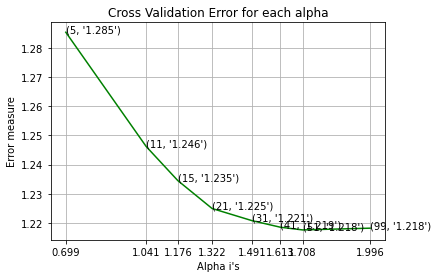

For values of best alpha =  51 The train log loss is: 1.1484632285759586
For values of best alpha =  51 The cross validation log loss is: 1.217648509332263
For values of best alpha =  51 The test log loss is: 1.2006303309409547
Number of mis-classified points : 0.48485197557885035


In [32]:
alpha = [5, 11, 15, 21, 31, 41, 51, 99]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = KNeighborsClassifier(n_neighbors=i)
    clf.fit(X_tr, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_tr, y_train)
    sig_clf_probs = sig_clf.predict_proba(X_cr)
    cv_log_error_array.append(log_loss(y_cv, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(y_cv, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(X_tr, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_tr,y_train)


predict_y = sig_clf.predict_proba(X_tr)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_cr)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_te)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

y_pred = sig_clf.predict(X_te)
print("Number of mis-classified points :", np.count_nonzero((y_pred- y_test))/y_test.shape[0])


-------------------- Confusion matrix --------------------


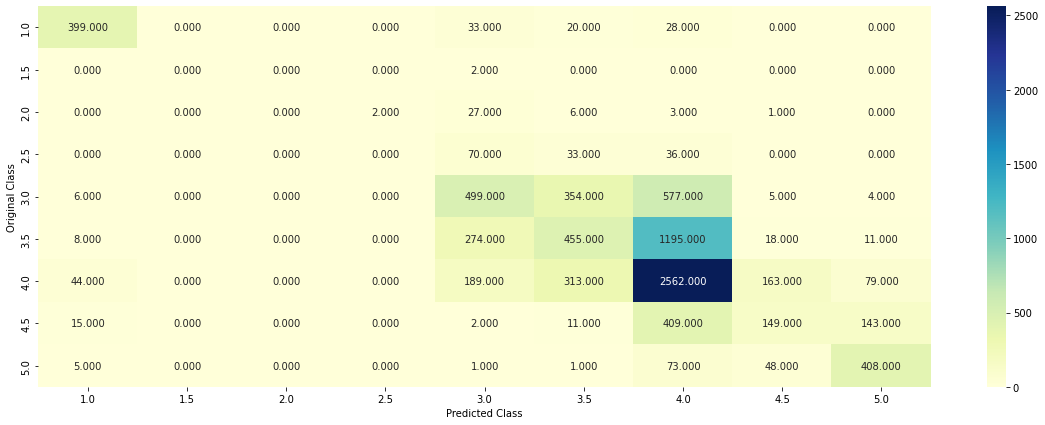

-------------------- Precision matrix (Columm Sum=1) --------------------


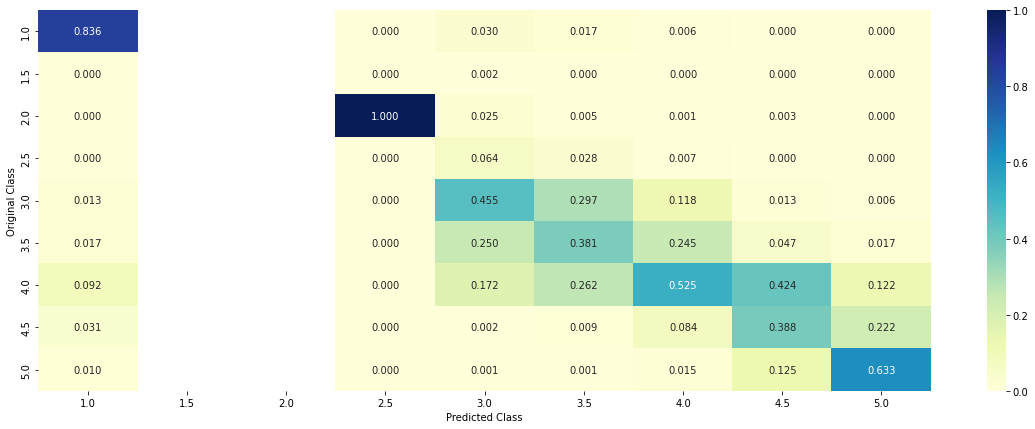

-------------------- Recall matrix (Row sum=1) --------------------


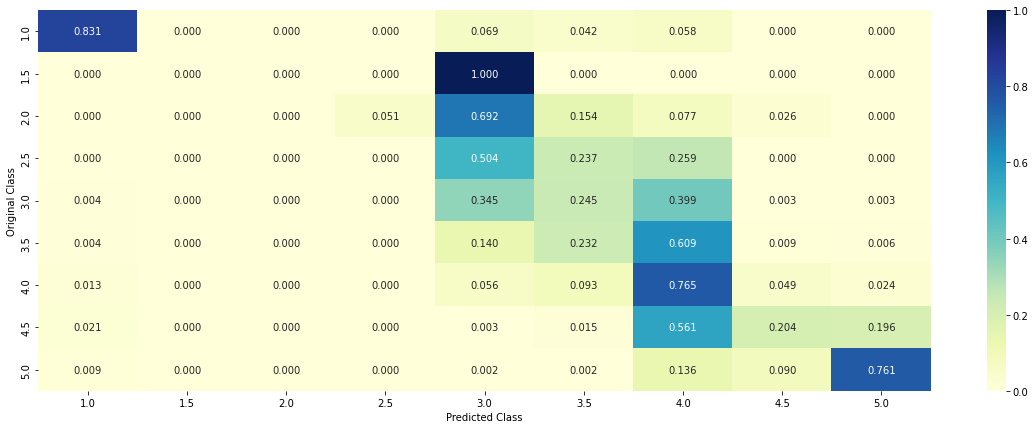

In [33]:
plot_confusion_matrix(y_test, y_pred)

##Logistic Regression

for alpha = 1e-06
Log Loss : 1.1651392522774602
for alpha = 1e-05
Log Loss : 1.1495632708625878
for alpha = 0.0001
Log Loss : 1.1485723621744683
for alpha = 0.001
Log Loss : 1.1677660091578481
for alpha = 0.01
Log Loss : 1.2148048258309208
for alpha = 0.1
Log Loss : 1.2833823392054982
for alpha = 1
Log Loss : 1.3123139086218116
for alpha = 10
Log Loss : 1.3160326630955566
for alpha = 100
Log Loss : 1.3263854146994656


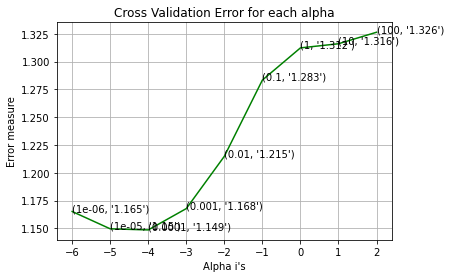

For values of best alpha =  0.0001 The train log loss is: 1.1185152033540007
For values of best alpha =  0.0001 The cross validation log loss is: 1.1485723621744683
For values of best alpha =  0.0001 The test log loss is: 1.1381506246248745
Number of mis-classified points : 0.4743693122912107


In [34]:
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(X_tr, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_tr, y_train)
    sig_clf_probs = sig_clf.predict_proba(X_cr)
    cv_log_error_array.append(log_loss(y_cv, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(y_cv, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(X_tr, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_tr,y_train)


predict_y = sig_clf.predict_proba(X_tr)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_cr)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_te)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

y_pred = sig_clf.predict(X_te)
print("Number of mis-classified points :", np.count_nonzero((y_pred- y_test))/y_test.shape[0])

-------------------- Confusion matrix --------------------


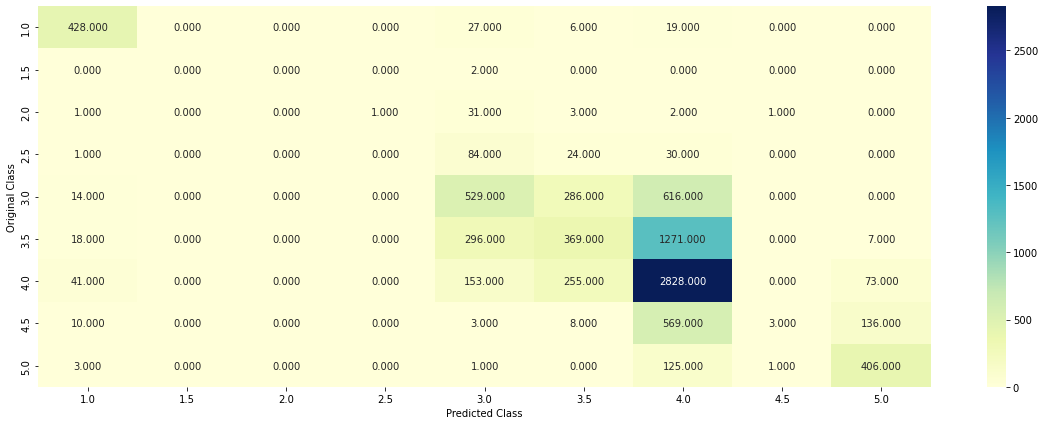

-------------------- Precision matrix (Columm Sum=1) --------------------


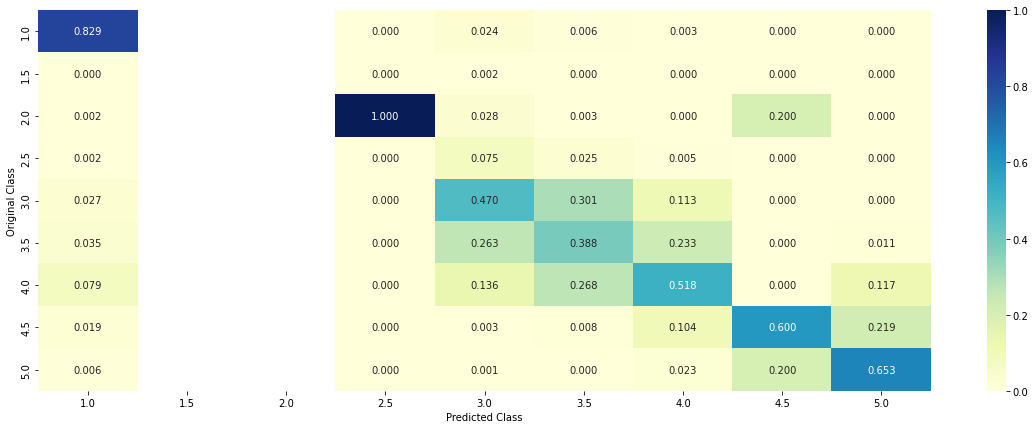

-------------------- Recall matrix (Row sum=1) --------------------


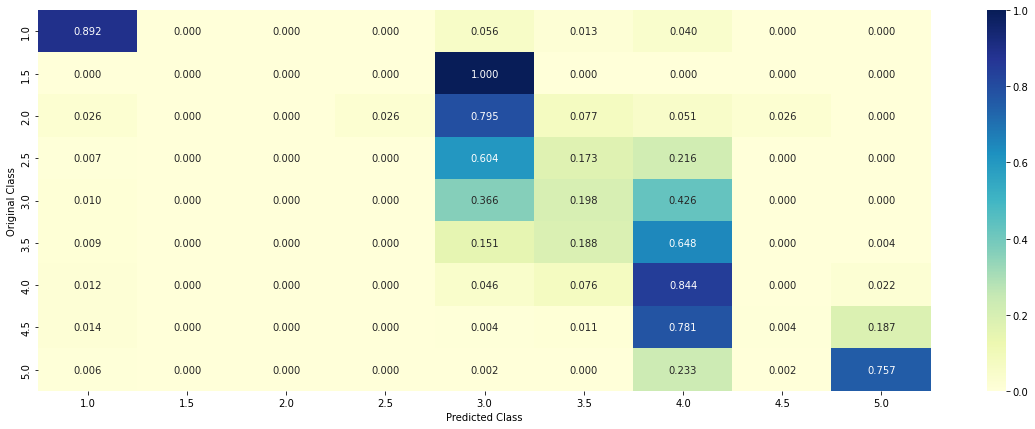

In [35]:
plot_confusion_matrix(y_test, y_pred)

##SVM

for alpha = 1e-06
Log Loss : 1.164707829333982
for alpha = 1e-05
Log Loss : 1.1684419757988254
for alpha = 0.0001
Log Loss : 1.172551308253079
for alpha = 0.001
Log Loss : 1.1815303925644194
for alpha = 0.01
Log Loss : 1.1892257258683754
for alpha = 0.1
Log Loss : 1.2217357556656518
for alpha = 1
Log Loss : 1.2572117264596168
for alpha = 10
Log Loss : 1.3864648315162402
for alpha = 100
Log Loss : 1.3308791591038363


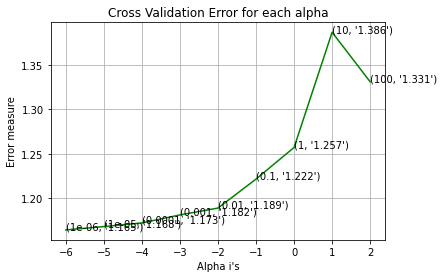

For values of best alpha =  1e-06 The train log loss is: 1.1142757347304784
For values of best alpha =  1e-06 The cross validation log loss is: 1.164707829333982
For values of best alpha =  1e-06 The test log loss is: 1.1555635509738986
Number of mis-classified points : 0.4690703835963599


In [36]:
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf.fit(X_tr, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_tr, y_train)
    sig_clf_probs = sig_clf.predict_proba(X_cr)
    cv_log_error_array.append(log_loss(y_cv, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(y_cv, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(X_tr, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_tr,y_train)


predict_y = sig_clf.predict_proba(X_tr)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_cr)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_te)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

y_pred = sig_clf.predict(X_te)
print("Number of mis-classified points :", np.count_nonzero((y_pred- y_test))/y_test.shape[0])

-------------------- Confusion matrix --------------------


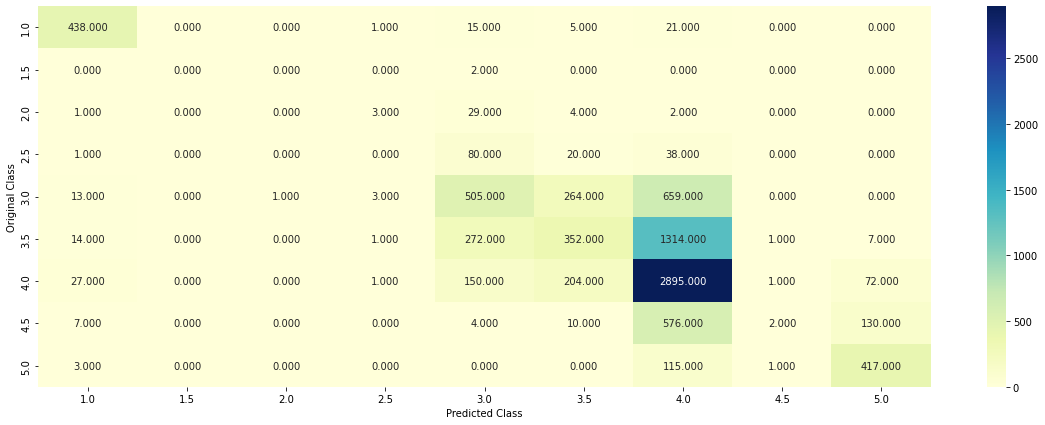

-------------------- Precision matrix (Columm Sum=1) --------------------


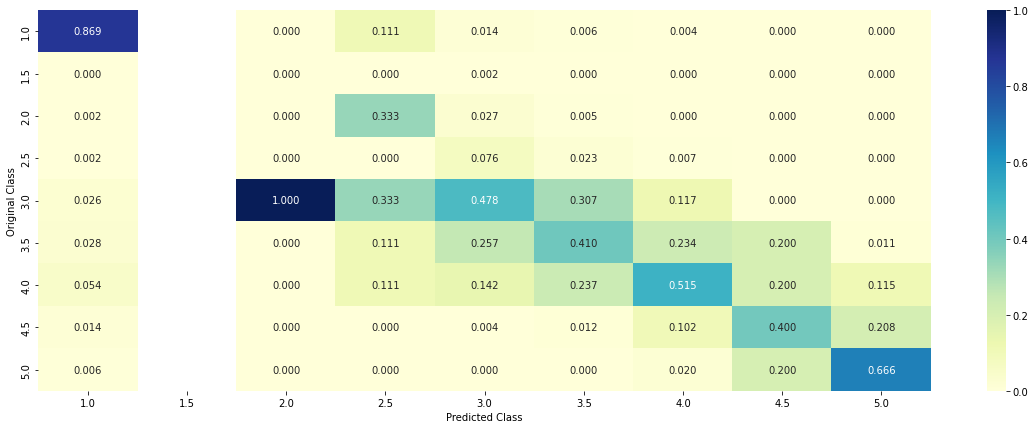

-------------------- Recall matrix (Row sum=1) --------------------


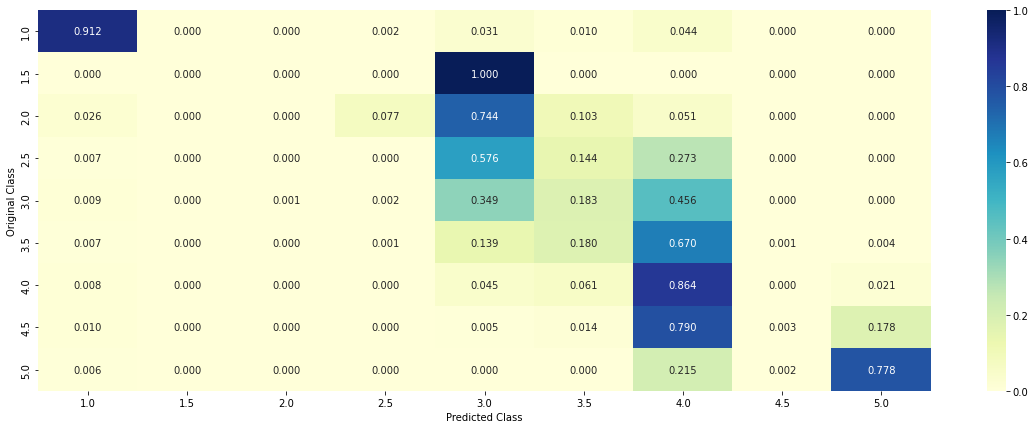

In [37]:
plot_confusion_matrix(y_test, y_pred)

##Random Forest 

In [38]:
alpha = [100,200,500,1000,2000]
max_depth = [5, 10]
cv_log_error_array = []
for i in alpha:
  for j in max_depth:
    print("for n_estimators =", i,"and max depth = ", j)
    clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
    clf.fit(X_tr, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_tr, y_train)
    sig_clf_probs = sig_clf.predict_proba(X_cr)
    cv_log_error_array.append(log_loss(y_cv, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(y_cv, sig_clf_probs)) 


best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/len(max_depth))], criterion='gini', max_depth=max_depth[int(best_alpha%len(max_depth))], random_state=42, n_jobs=-1)
clf.fit(X_tr, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_tr,y_train)


predict_y = sig_clf.predict_proba(X_tr)
print('For values of best estimator = ', alpha[int(best_alpha/len(max_depth))], ' and best max depth = ',max_depth[int(best_alpha%len(max_depth))], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_cr)
print('For values of best estimator = ', alpha[int(best_alpha/len(max_depth))], ' and best max depth = ',max_depth[int(best_alpha%len(max_depth))], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_te)
print('For values of best estimator = ', alpha[int(best_alpha/len(max_depth))], ' and best max depth = ',max_depth[int(best_alpha%len(max_depth))], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

y_pred = sig_clf.predict(X_te)
print("Number of mis-classified points :", np.count_nonzero((y_pred- y_test))/y_test.shape[0])

for n_estimators = 100 and max depth =  5
Log Loss : 1.2205562208584453
for n_estimators = 100 and max depth =  10
Log Loss : 1.1790534646826842
for n_estimators = 200 and max depth =  5
Log Loss : 1.2232010700521703
for n_estimators = 200 and max depth =  10
Log Loss : 1.1808381413297824
for n_estimators = 500 and max depth =  5
Log Loss : 1.2225497094256959
for n_estimators = 500 and max depth =  10
Log Loss : 1.179745942432413
for n_estimators = 1000 and max depth =  5
Log Loss : 1.2225332413111696
for n_estimators = 1000 and max depth =  10
Log Loss : 1.180461780137825
for n_estimators = 2000 and max depth =  5
Log Loss : 1.2227157246581541
for n_estimators = 2000 and max depth =  10
Log Loss : 1.1799549558546794
For values of best estimator =  100  and best max depth =  10 The train log loss is: 0.9205546645917986
For values of best estimator =  100  and best max depth =  10 The cross validation log loss is: 1.1790534646826842
For values of best estimator =  100  and best max dept

-------------------- Confusion matrix --------------------


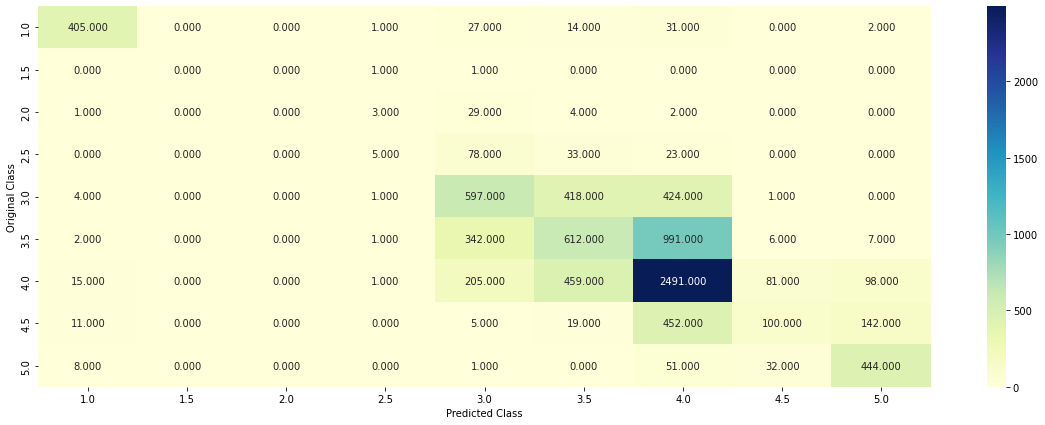

-------------------- Precision matrix (Columm Sum=1) --------------------


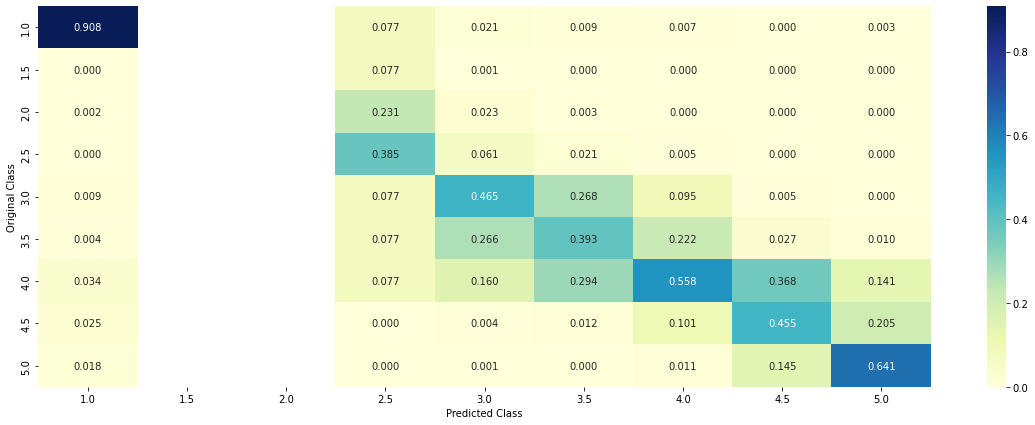

-------------------- Recall matrix (Row sum=1) --------------------


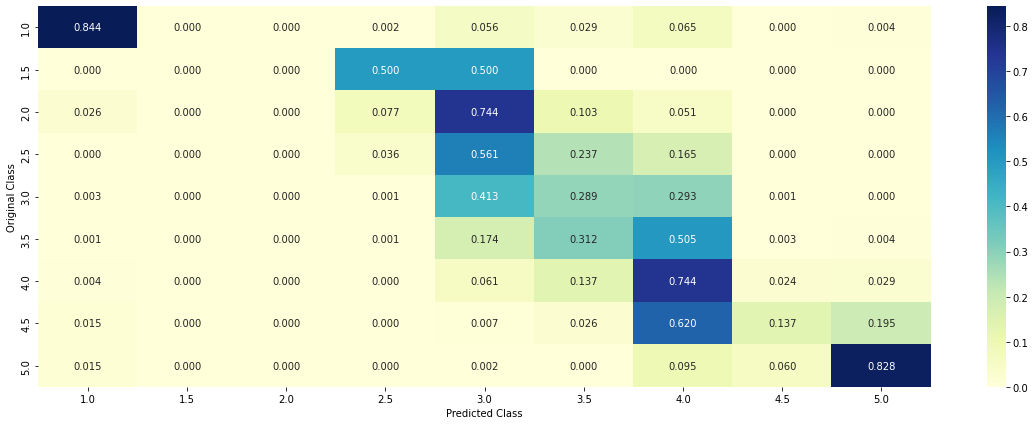

In [39]:
plot_confusion_matrix(y_test, y_pred)

In [40]:
import pickle
filename = 'finalized_model.pkl'
pickle.dump(sig_clf, open(filename, 'wb'))

In [ ]:
#model = pickle.load(open('/content/finalized_model.pkl', 'rb'))
#y_pred = model.predict(X_te)
#plot_confusion_matrix(y_test, y_pred)

##Conclusions

1. One Hot Encoding didn't failed to perform. The model trained using one hot encoding predicted engine rating to be 4.0 for all the datapoints.

2. Response encoding and bow vectorization techniques proved to work for this problem. Both these techniques gave almost similar performance.

3. Model training was done using KNN, Logistic Regression, SVM and Random Forest. Among these models, logistic regression and random forest model gave almost equal performance. Based on the business constraints, we can choose between these models accordingly.

4. The model is able to classify the datapoints belonging to rating 1.0, 4.0 and 5.0 fairly well. But, the model fails to classify the datapoints belonging to rating 3.0, 3.5 and 4.5. This trends was also observed in EDA. 

5. Percentage of datapoints belonging to rating 1.5, 2.0 and 2.5 is very less and so, model is not learning to classify then as well. 

6. One main problem with the dataset is the large amount of missing values. Almost 36 features had missing values greater than 90%. This makes it hard to learn from the dataset. 

##What could be improved?

1. Can try some missing value imputation techniques. (Mean, Median or Model based imputation).

2. Improve hyperparameter tuning.

3. Try TF-IDF Vectorization for encoding categorical features. 